## Forecasting macroeconomic variables with multi-variate time-series models

In this notebook, we'll try to predict the trend of US real GDP and US GDP deflator with the aid of multi-variate models such as VAR, VECM and VARMA. We will use the data from the FRED database and the statsmodels library to build our models and make our forecasts. 

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-bright')

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import scipy

from fredapi import Fred
fred = Fred(api_key='my_key')

import warnings
warnings.filterwarnings('ignore')

## Load data

We are going to select several economic variables for these models:

- Real GDP
- GDP Deflator
- Total Employees Non-farm
- REER
- Money supply (M2)
- Real disposable income
- Personal Consumption Expenditure
- New orders for durable goods
- Crude Oil price
- New housing starts

For the sake of simplicity when dealing with transformation, we have decided to select only levels and prices formats for our variables. Generally, as stated in https://www.princeton.edu/~mwatson/papers/favar.pdf, first differences of logarithms (growth rates) are used for real quantity variables, first differences are used for nominal interest rates, and second differences of logarithms (changes in growth rates) for price series.

In [2]:
#Fetch quarterly real GDP data from FRED
df_orig = pd.DataFrame()

df_orig['rgdp'] = fred.get_series('GDPC1')
df_orig['gdp_defl'] = fred.get_series('GDPDEF')
df_orig['labor'] = fred.get_series('PAYEMS', frequency='q', aggregation_method='avg')
df_orig['reer'] = fred.get_series('RBUSBIS', frequency='q', aggregation_method='avg')
df_orig['m2'] = fred.get_series('M2REAL', frequency='q', aggregation_method='avg')
df_orig['disp_inc'] = fred.get_series('DSPIC96', frequency='q', aggregation_method='avg')
df_orig['pce'] = fred.get_series('pce',  frequency='q', aggregation_method='avg')
df_orig['new_ord'] = fred.get_series('DGORDER', frequency='q', aggregation_method='avg')
df_orig['oil'] = fred.get_series('POILWTIUSDM', frequency='q', aggregation_method='avg')
df_orig['houst'] = fred.get_series('HOUST', frequency='q', aggregation_method='avg')

df_orig.head()

rgdp  gdp_defl    labor  reer  m2  disp_inc  pce  new_ord  \
1947-01-01  2034.450    11.952  43566.0   NaN NaN       NaN  NaN      NaN   
1947-04-01  2029.024    12.122  43649.0   NaN NaN       NaN  NaN      NaN   
1947-07-01  2024.834    12.326  43969.0   NaN NaN       NaN  NaN      NaN   
1947-10-01  2056.508    12.630  44492.0   NaN NaN       NaN  NaN      NaN   
1948-01-01  2087.442    12.731  44632.0   NaN NaN       NaN  NaN      NaN   

            oil  houst  
1947-01-01  NaN    NaN  
1947-04-01  NaN    NaN  
1947-07-01  NaN    NaN  
1947-10-01  NaN    NaN  
1948-01-01  NaN    NaN

For the variables with a higher frequency than quarterly, we have used the "avg" aggregation method from FRED api.

In [3]:
round(df_orig.describe(), 2)

rgdp  gdp_defl      labor    reer       m2  disp_inc       pce  \
count    299.00    299.00     299.00  111.00   251.00    251.00    251.00   
mean    8924.62     53.52   95743.17  109.88  2773.73   7572.41   5140.92   
std     5319.78     33.99   34475.12    8.95  1422.16   3905.03   4538.38   
min     2024.83     11.95   43235.00   93.65   992.80   2200.10    309.50   
25%     4256.26     17.87   61620.00  102.06  1834.70   4241.25    954.20   
50%     7617.55     52.64   94123.00  110.91  2392.10   6811.00   3783.40   
75%    13584.43     81.84  130689.50  116.23  3367.75  11038.00   9027.75   
max    19478.89    119.12  151866.00  128.66  7616.30  17218.80  15965.00   

         new_ord     oil    houst  
count     119.00  127.00   251.00  
mean   195496.26   47.88  1430.67  
std     35383.08   28.50   382.42  
min    117280.00   12.90   526.00  
25%    170695.00   21.71  1190.50  
50%    192653.00   42.89  1456.00  
75%    224354.50   67.01  1657.00  
max    260839.00  124.07  2424.00

After a first look at the main stats of our data set, we see that some variables have almost 300 observations, while others less than 120. We may decide to discard those variables with too few observations, but we prefer to keep them all and train our model on a shorter time frame. From a macroeconomic standpoint, this is not necessarily harmful, since we know that some important structural breaks have happened after the 1980s (e.g. inflation trends).

In [4]:
#Before deleting the selected variables, let's make a copy of our original data set
df = df_orig.copy()

In [5]:
df.tail()

rgdp  gdp_defl     labor    reer      m2  disp_inc      pce  \
2020-07-01  18560.774   113.888  140860.0  118.91  7105.1   15783.1  14293.8   
2020-10-01  18767.778   114.439  142619.0  115.05  7259.1   15442.9  14467.6   
2021-01-01  19055.655   115.652  143355.0  113.34  7462.9   17218.8  15005.5   
2021-04-01  19368.310   117.413  145056.0  114.85  7561.3   15806.6  15681.7   
2021-07-01  19478.893   119.115  147441.0  117.15  7616.3   15633.2  15965.0   

             new_ord        oil   houst  
2020-07-01  222825.0  40.907944  1440.0  
2020-10-01  233367.0  42.713216  1575.0  
2021-01-01  246296.0  57.790333  1599.0  
2021-04-01  253612.0  66.102648  1588.0  
2021-07-01  260839.0  70.589848  1562.0

We have our aggregated and non-aggregated quarterly variables up to the third quarter of 2021, but the starting period differs among them. Therefore, in order to have all columns of the same period length, we delete the initial observations where we have NaNs. 

In [6]:
df.dropna(axis=0, inplace=True)
df.describe()

rgdp    gdp_defl          labor        reer           m2  \
count    111.000000  111.000000     111.000000  111.000000   111.000000   
mean   15064.405387   91.872018  134021.954955  109.882883  3955.328829   
std     2563.774860   13.971241    9040.013819    8.948915  1347.479966   
min    10195.338000   69.793000  112873.000000   93.650000  2314.000000   
25%    13233.696500   78.946000  130410.500000  102.065000  2830.600000   
50%    15379.155000   93.327000  132987.000000  110.910000  3541.200000   
75%    17102.925500  104.045000  138922.000000  116.230000  4864.150000   
max    19478.893000  119.115000  151866.000000  128.660000  7616.300000   

           disp_inc           pce        new_ord         oil        houst  
count    111.000000    111.000000     111.000000  111.000000   111.000000  
mean   11382.534234   9549.157658  200553.774775   51.722683  1330.018018  
std     2335.787919   3089.213877   30947.199935   28.475637   414.030850  
min     7380.700000   4621.200000  137396.000000   12.896667   526.000000  
25%     9661.650000   6956.950000  176143.500000   27.170000  1056.500000  
50%    11529.300000   9805.500000  201132.000000   48.346708  1417.000000  
75%    12979.800000  11994.050000  225042.500000   70.481840  1599.500000  
max    17218.800000  15965.000000  260839.000000  124.067078  2120.000000

In [7]:
df.head()

rgdp  gdp_defl     labor    reer      m2  disp_inc     pce  \
1994-01-01  10195.338    69.793  112873.0  104.88  2370.1    7380.7  4621.2   
1994-04-01  10333.495    70.130  113915.0  103.96  2361.4    7455.0  4683.2   
1994-07-01  10393.898    70.532  114918.0  101.45  2341.6    7498.5  4752.7   
1994-10-01  10512.962    70.915  115831.0  100.67  2327.6    7606.1  4826.7   
1995-01-01  10550.251    71.300  116702.0  103.38  2314.0    7671.0  4862.5   

             new_ord        oil   houst  
1994-01-01  137396.0  14.810000  1391.0  
1994-04-01  142676.0  17.783333  1467.0  
1994-07-01  145461.0  18.493333  1454.0  
1994-10-01  150691.0  17.646667  1472.0  
1995-01-01  152401.0  18.373333  1324.0

Now we have a 10-variable data set with a total of 111 quarterly observations starting on January 1st 1994.

## Exploratory Data Analysis

### Visual inspection

It is considered best practice to start by visually inspecting the time-series in order to have an idea of their characteristics.

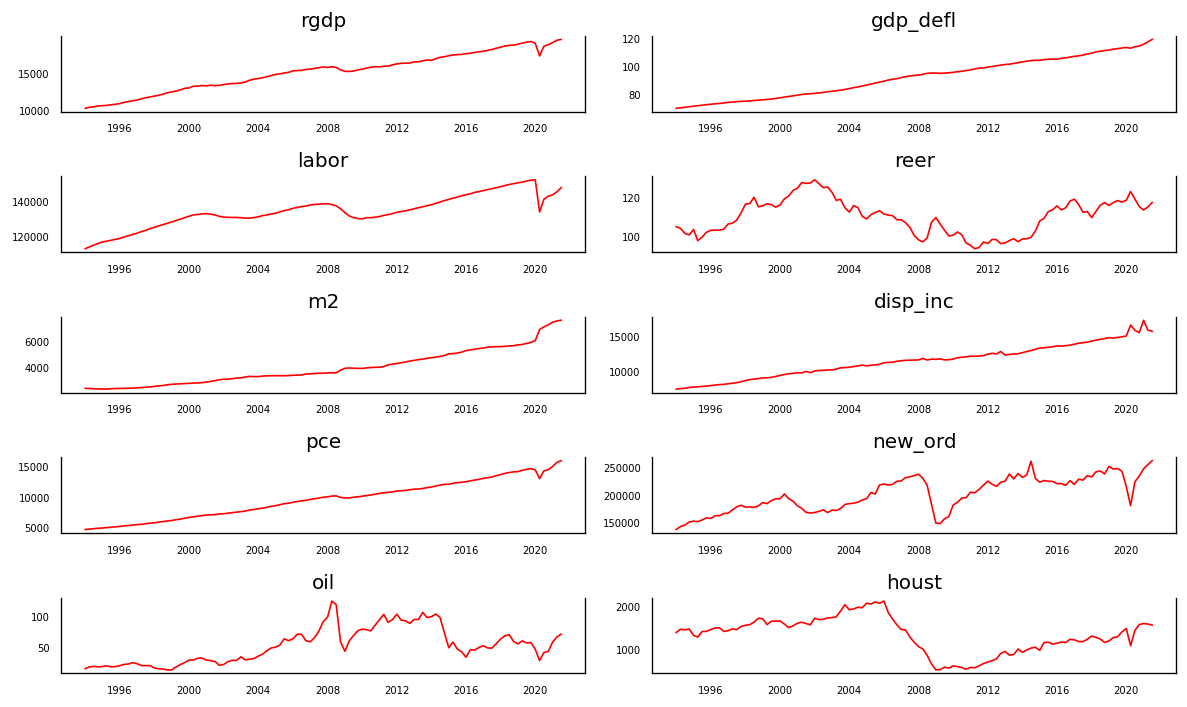

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    #Make charts more readable
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

From the charts shown above, we immediately see that these time-series do not appear to be stationary. At first glance, we also observe typical features of economic variables, such as trends, heteroscedasticity, seasonality and structural breaks. So, let's move on with our EDA to confirm our suspects.

### Violin plot

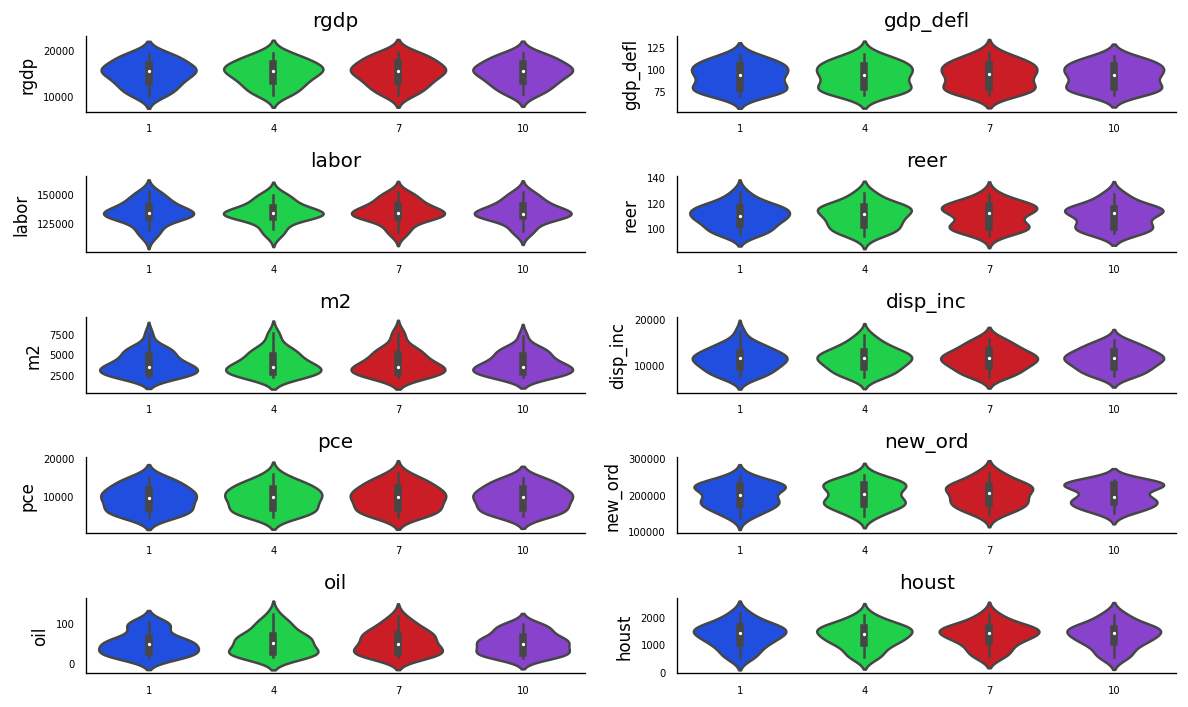

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    sns.violinplot(x=data.index.month, y=data, ax=ax)
    #Make charts more readable
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

sns.despine()
plt.tight_layout();

The violin plot, useful to detect seasonal patterns, does not seem to highlight the presence of seasonality, but a series decomposition may reveal some hidden components of our time-series.

### Seasonal decompose

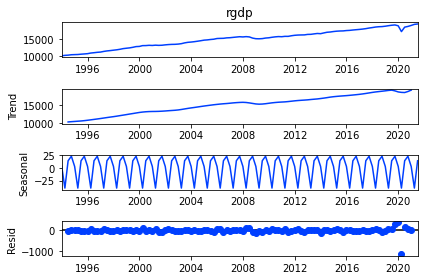

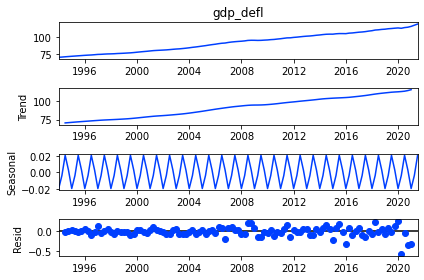

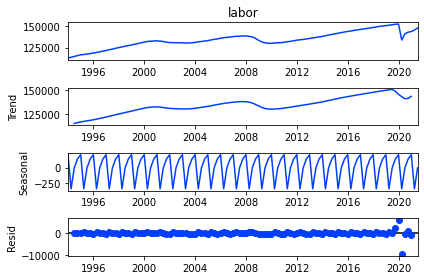

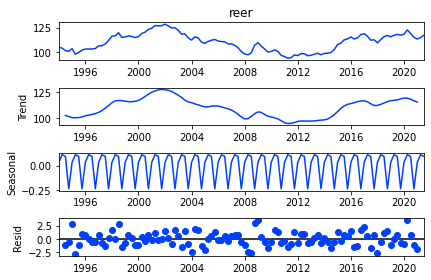

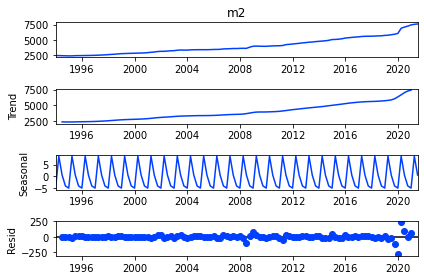

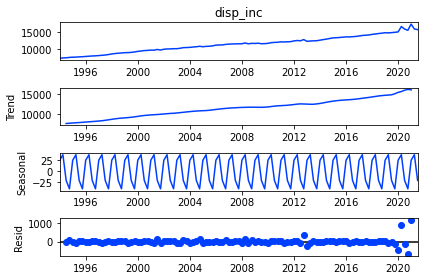

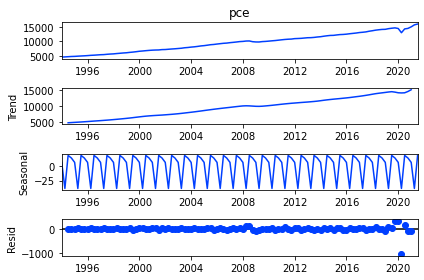

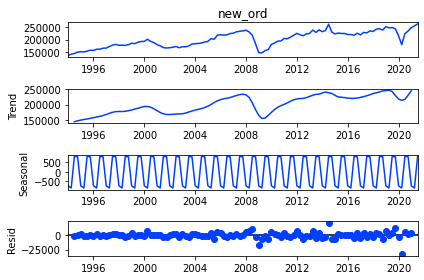

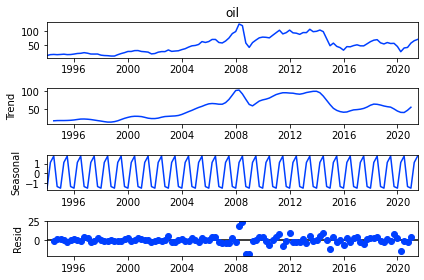

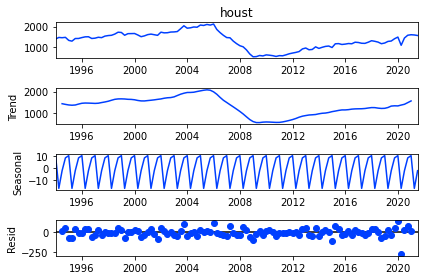

In [10]:
for i, ax in enumerate(axes.flatten()):
    data = seasonal_decompose(df[df.columns[i]], model= 'additive')
    ax = data.plot()
    
plt.tight_layout();

After applying the seasonal_decompose method to our series, we can better break down each of them into their different components: notably, 

- Trend; 
- Seasonality; 
- Residuals.

Above we can have a look at the decomposition of our first three time-series and the importance of each of them.

### ACF plot

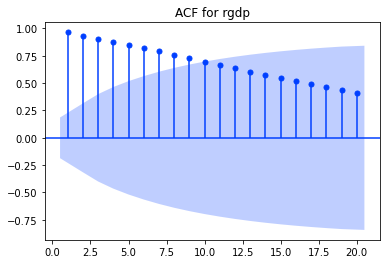

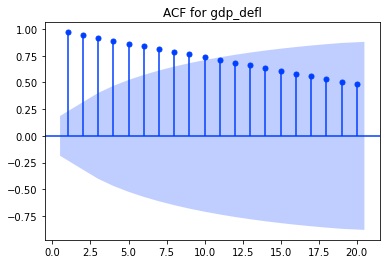

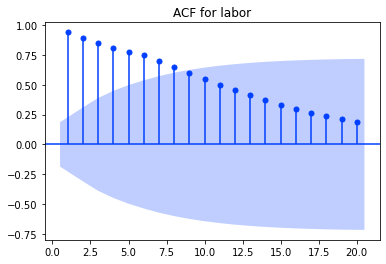

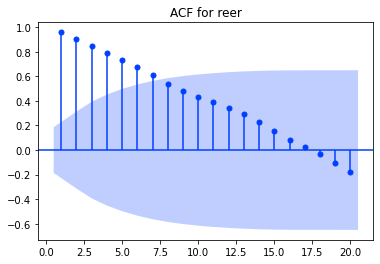

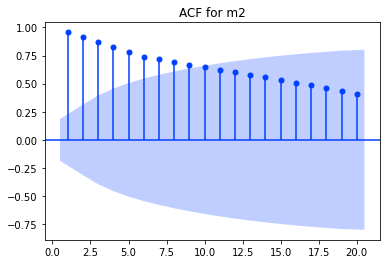

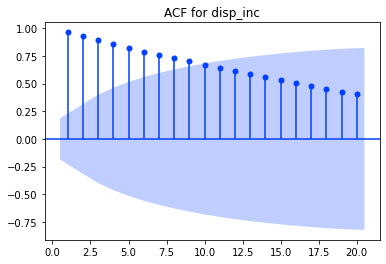

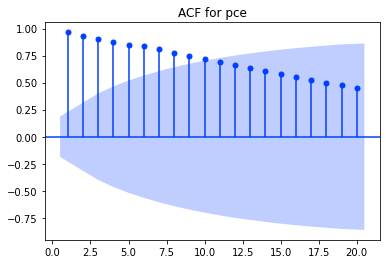

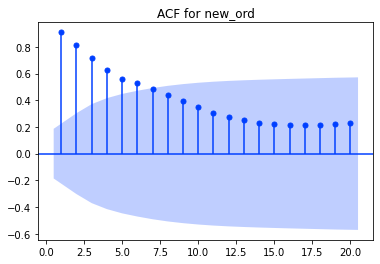

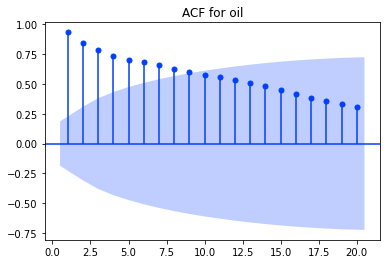

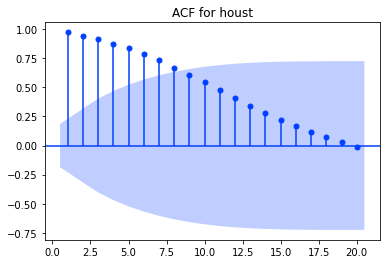

In [11]:
for i in df:
    sgt.plot_acf(df[i], lags = 20, zero=False)
    plt.title('ACF for %s' % i) 
    plt.show()

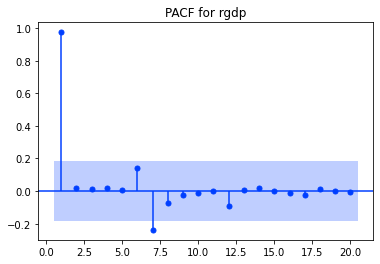

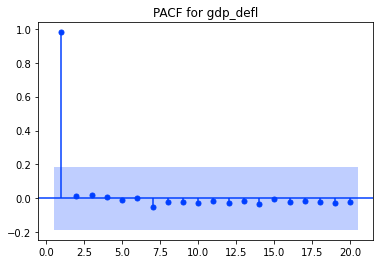

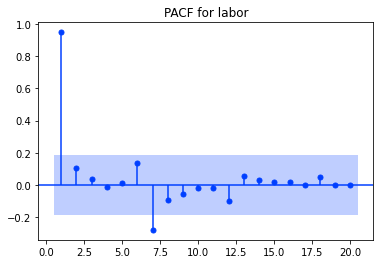

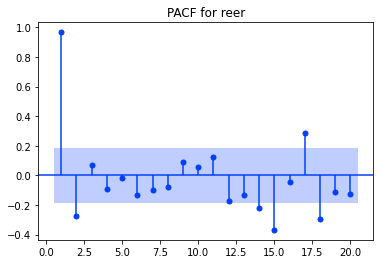

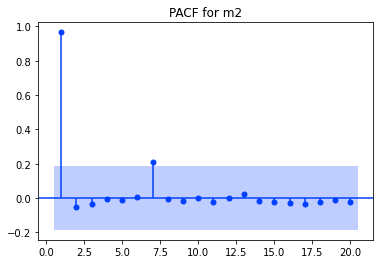

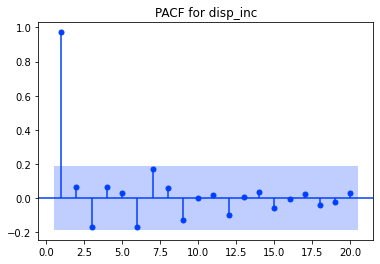

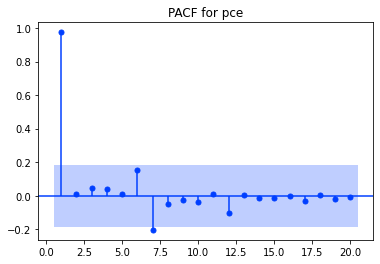

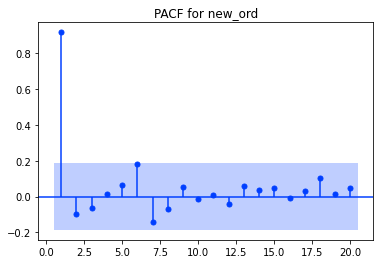

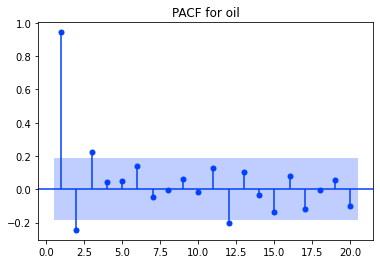

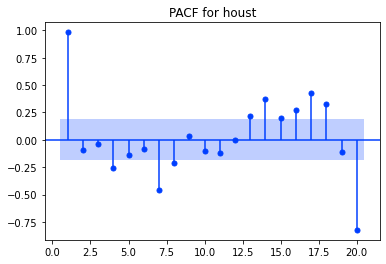

In [12]:
for i in df:
    sgt.plot_pacf(df[i], lags = 20, zero=False)
    plt.title('PACF for %s' % i) 
    plt.show()

From the ACF and PACF plots above we can clearly see that there is autocorrelation among the variables for several lags: this is an important indication of non-stationarity. We will need to transform our data in order to make it stationary, otherwise some of our models won't be reliable

### ADF test for stationarity

In [13]:
def adf_test(timeseries, name):
    dftest = sts.adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print('\033[1m{:10s}\033[0m'.format(name))
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=4).mean()
    rolstd = timeseries.rolling(window=4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

rgdp      
Test Statistic           -0.778388
p-value                   0.825388
Lags Used                 1.000000
Observations Used       109.000000
Critical Value (1%)      -3.491818
Critical Value (5%)      -2.888444
Critical Value (10%)     -2.581120
dtype: float64


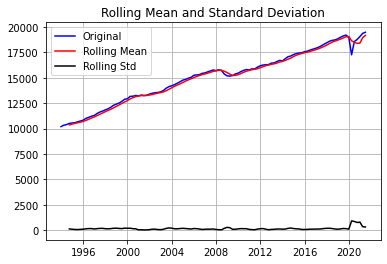

gdp_defl  
Test Statistic            1.705173
p-value                   0.998141
Lags Used                 2.000000
Observations Used       108.000000
Critical Value (1%)      -3.492401
Critical Value (5%)      -2.888697
Critical Value (10%)     -2.581255
dtype: float64


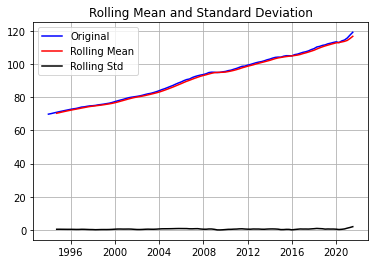

labor     
Test Statistic           -1.823773
p-value                   0.368724
Lags Used                 1.000000
Observations Used       109.000000
Critical Value (1%)      -3.491818
Critical Value (5%)      -2.888444
Critical Value (10%)     -2.581120
dtype: float64


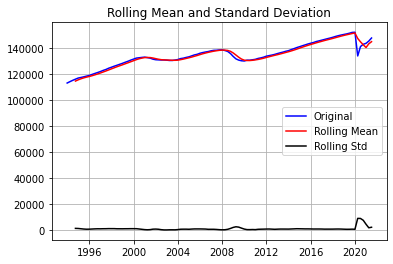

reer      
Test Statistic           -1.780293
p-value                   0.390288
Lags Used                 1.000000
Observations Used       109.000000
Critical Value (1%)      -3.491818
Critical Value (5%)      -2.888444
Critical Value (10%)     -2.581120
dtype: float64


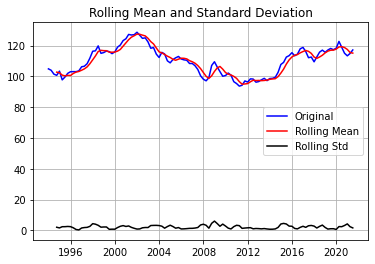

m2        
Test Statistic            2.933028
p-value                   1.000000
Lags Used                 1.000000
Observations Used       109.000000
Critical Value (1%)      -3.491818
Critical Value (5%)      -2.888444
Critical Value (10%)     -2.581120
dtype: float64


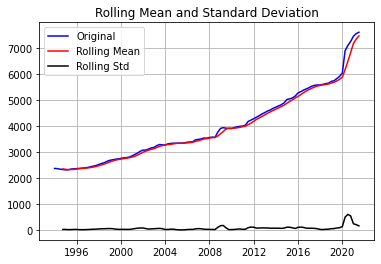

disp_inc  
Test Statistic            0.933127
p-value                   0.993508
Lags Used                 3.000000
Observations Used       107.000000
Critical Value (1%)      -3.492996
Critical Value (5%)      -2.888955
Critical Value (10%)     -2.581393
dtype: float64


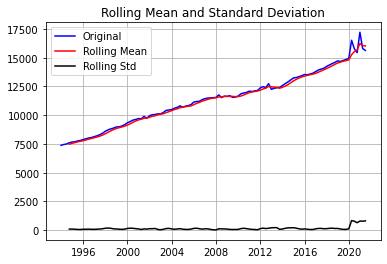

pce       
Test Statistic            1.109572
p-value                   0.995297
Lags Used                 5.000000
Observations Used       105.000000
Critical Value (1%)      -3.494220
Critical Value (5%)      -2.889485
Critical Value (10%)     -2.581676
dtype: float64


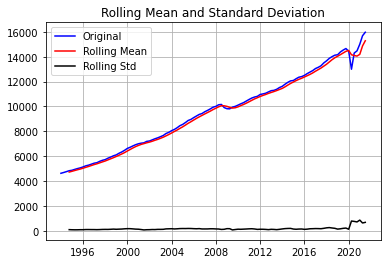

new_ord   
Test Statistic           -1.992940
p-value                   0.289677
Lags Used                 1.000000
Observations Used       109.000000
Critical Value (1%)      -3.491818
Critical Value (5%)      -2.888444
Critical Value (10%)     -2.581120
dtype: float64


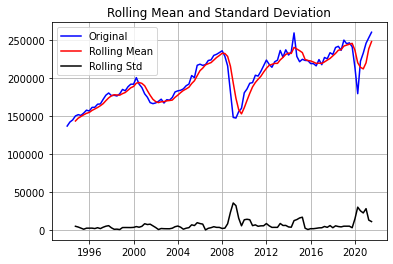

oil       
Test Statistic           -1.912699
p-value                   0.326111
Lags Used                 2.000000
Observations Used       108.000000
Critical Value (1%)      -3.492401
Critical Value (5%)      -2.888697
Critical Value (10%)     -2.581255
dtype: float64


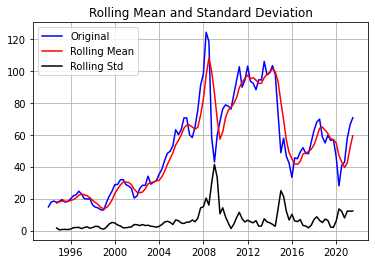

houst     
Test Statistic           -2.293666
p-value                   0.174019
Lags Used                 6.000000
Observations Used       104.000000
Critical Value (1%)      -3.494850
Critical Value (5%)      -2.889758
Critical Value (10%)     -2.581822
dtype: float64


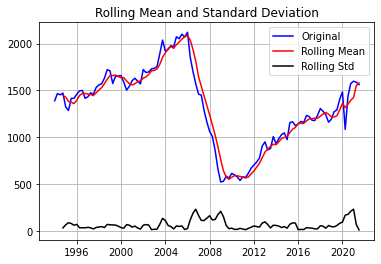

In [14]:
for i in df:
    adf_test(df[i], i)

From the ADF tests we notice that all series are not stationary. However, the ADF test is not always 100% precise, so we need to be careful when deciding if transform our data or not.

## Split the data set

Before transforming our data set to make it stationary, we split it into a train and test set in order to validate our model selection with a hold-out set.

In [15]:
size = int(len(df) * 0.90)
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [16]:
print(len(df_train))
print(len(df_test))

99
12


We decide to estimate our parameters without taking into consideration the outbreak of Covid-19. This is because we want to avoid our model from being impacted by a shock that would distorte our estimations, due to the magnitude of the volatility of our variables. This is also acceptable according to: https://www.ecb.europa.eu/pub/pdf/scpwps/ecb.wp2461~fe732949ee.en.pdf. Of course, we assume that the shock is temporary and that the "normal" model still holds in the future.

In [17]:
df_train.tail()

rgdp  gdp_defl     labor    reer      m2  disp_inc      pce  \
2017-07-01  18126.226   107.903  146875.0  112.13  5571.4   14015.5  13268.1   
2017-10-01  18296.685   108.670  147405.0  112.56  5584.6   14084.2  13497.4   
2018-01-01  18436.262   109.261  147988.0  109.45  5586.0   14253.3  13667.4   
2018-04-01  18590.004   110.234  148648.0  112.62  5609.2   14373.0  13864.8   
2018-07-01  18679.599   110.597  149218.0  115.73  5637.9   14491.8  14002.6   

             new_ord        oil   houst  
2017-07-01  225920.0  48.137246  1179.0  
2017-10-01  233874.0  55.412460  1236.0  
2018-01-01  231622.0  62.856107  1308.0  
2018-04-01  240766.0  67.911981  1279.0  
2018-07-01  242307.0  69.721853  1240.0

In [18]:
df_test.head()

rgdp  gdp_defl     labor    reer      m2  disp_inc      pce  \
2018-10-01  18721.281   111.175  149717.0  117.05  5653.4   14599.1  14119.3   
2019-01-01  18833.195   111.514  150168.0  115.63  5722.2   14729.6  14155.6   
2019-04-01  18982.528   112.152  150582.0  117.11  5746.4   14679.3  14375.7   
2019-07-01  19112.653   112.517  151117.0  118.13  5831.5   14763.1  14529.5   
2019-10-01  19202.310   112.978  151734.0  117.32  5911.5   14850.5  14653.9   

             new_ord        oil   houst  
2018-10-01  237090.0  58.651423  1162.0  
2019-01-01  250490.0  54.832400  1196.0  
2019-04-01  245748.0  59.762129  1274.0  
2019-07-01  246893.0  56.401643  1293.0  
2019-10-01  241728.0  56.982445  1405.0

## Forecasting window

For our out-of-sample predictions, we use a time-frame ranging from the fourth quarter of 2018 up to the fourth quarter of 2019 (a five-quarter time span). This is because we want to avoid having our parameters being influenced by an external shock (i.e. Covid-19). Nevertheless, this may have consequences on our forecasts, as we may underestimate uncertainty. 

In [19]:
#Create variables that will help us change the periods easily instead of typing them up every time
start_date = "2018-10-01"
end_date = "2019-10-01"

In [20]:
df_test_to_plot = df_test[start_date:end_date]
df_test_to_plot

rgdp  gdp_defl     labor    reer      m2  disp_inc      pce  \
2018-10-01  18721.281   111.175  149717.0  117.05  5653.4   14599.1  14119.3   
2019-01-01  18833.195   111.514  150168.0  115.63  5722.2   14729.6  14155.6   
2019-04-01  18982.528   112.152  150582.0  117.11  5746.4   14679.3  14375.7   
2019-07-01  19112.653   112.517  151117.0  118.13  5831.5   14763.1  14529.5   
2019-10-01  19202.310   112.978  151734.0  117.32  5911.5   14850.5  14653.9   

             new_ord        oil   houst  
2018-10-01  237090.0  58.651423  1162.0  
2019-01-01  250490.0  54.832400  1196.0  
2019-04-01  245748.0  59.762129  1274.0  
2019-07-01  246893.0  56.401643  1293.0  
2019-10-01  241728.0  56.982445  1405.0

## Data transformation

Now, let's transform the data applying the natural logarithm first, and then differencing it in order to make our time-series stationary.

### Log transformation

In [21]:
#We apply the log to make the variance constant
df_train_log = np.log(df_train)

In [22]:
df_train_log.head()

rgdp  gdp_defl      labor      reer        m2  disp_inc  \
1994-01-01  9.229686  4.245534  11.634019  4.652817  7.770687  8.906624   
1994-04-01  9.243146  4.250351  11.643208  4.644006  7.767010  8.916640   
1994-07-01  9.248974  4.256067  11.651974  4.619566  7.758590  8.922458   
1994-10-01  9.260364  4.261482  11.659888  4.611848  7.752593  8.936706   
1995-01-01  9.263905  4.266896  11.667379  4.638412  7.746733  8.945202   

                 pce    new_ord       oil     houst  
1994-01-01  8.438410  11.830623  2.695303  7.237778  
1994-04-01  8.451737  11.868332  2.878262  7.290975  
1994-07-01  8.466468  11.887663  2.917410  7.282074  
1994-10-01  8.481918  11.922987  2.870547  7.294377  
1995-01-01  8.489308  11.934270  2.910900  7.188413

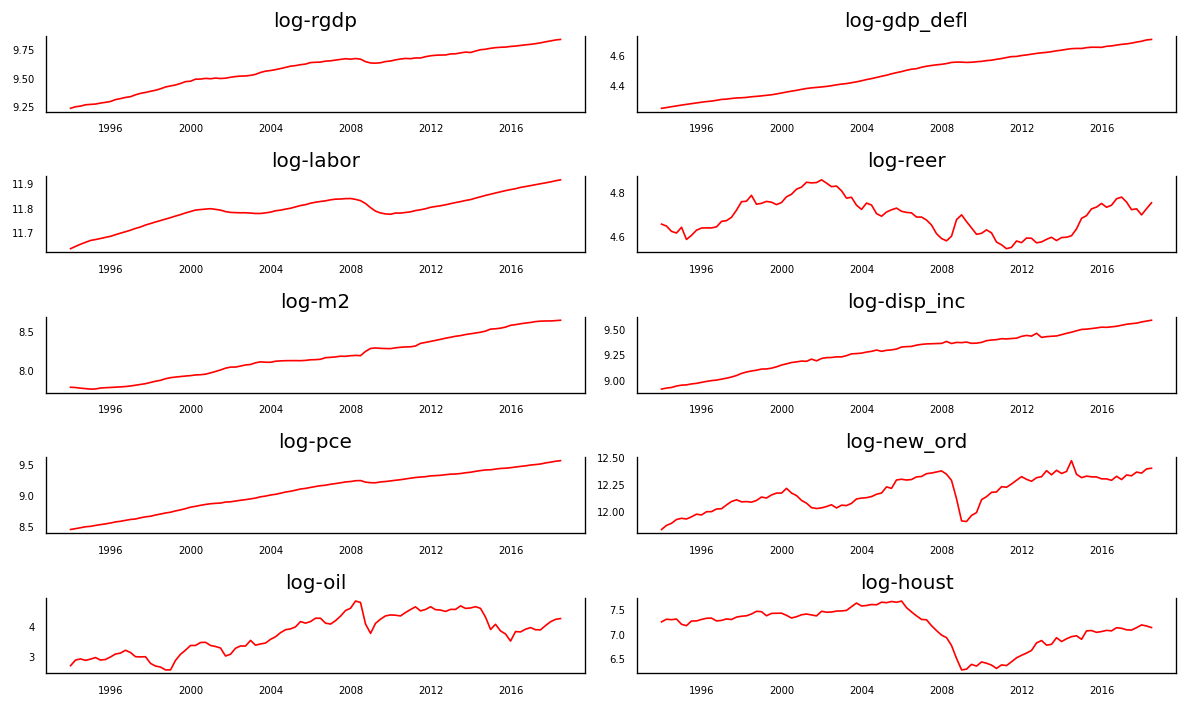

In [124]:
fig, axes = plt.subplots(nrows=int(len(df_train.columns)/2), ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_train_log[df_train_log.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    #Make charts more readable
    ax.set_title("log-" + df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

After the log transformation of our variables, we should have dealt with scale issues and skewness.

### First difference

In order to make our time-series stationary, we try integrating them once and see if we reach our goal.

In [24]:
#Let's difference our series once and drop NA values
df_train_log_diff = (df_train_log).diff().dropna()

In [25]:
df_train_log_diff.shape

(98, 10)

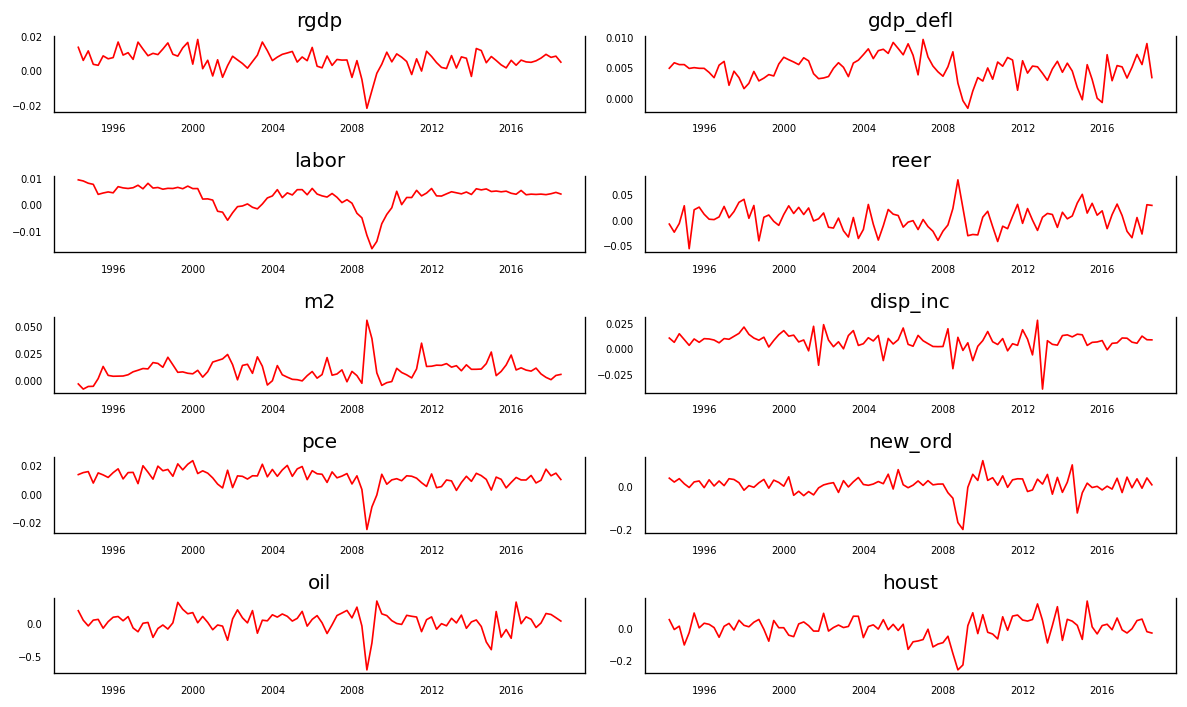

In [26]:
fig, axes = plt.subplots(nrows=int(len(df_train_log_diff.columns)/2), ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_train_log_diff[df_train_log_diff.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    #Make charts more readable
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Now it seems our series are pretty stationary, but let's run an ADF test to confirm it.

rgdp      
Test Statistic          -4.271515
p-value                  0.000497
Lags Used                1.000000
Observations Used       96.000000
Critical Value (1%)     -3.500379
Critical Value (5%)     -2.892152
Critical Value (10%)    -2.583100
dtype: float64


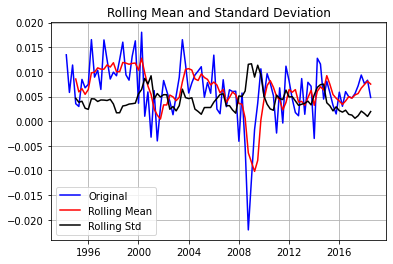

gdp_defl  
Test Statistic          -4.254931
p-value                  0.000531
Lags Used                1.000000
Observations Used       96.000000
Critical Value (1%)     -3.500379
Critical Value (5%)     -2.892152
Critical Value (10%)    -2.583100
dtype: float64


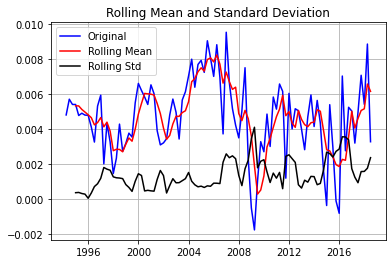

labor     
Test Statistic          -3.200836
p-value                  0.019936
Lags Used                2.000000
Observations Used       95.000000
Critical Value (1%)     -3.501137
Critical Value (5%)     -2.892480
Critical Value (10%)    -2.583275
dtype: float64


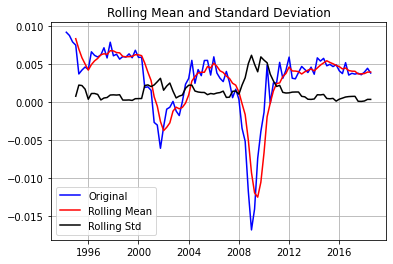

reer      
Test Statistic         -7.516912e+00
p-value                 3.881482e-11
Lags Used               0.000000e+00
Observations Used       9.700000e+01
Critical Value (1%)    -3.499637e+00
Critical Value (5%)    -2.891831e+00
Critical Value (10%)   -2.582928e+00
dtype: float64


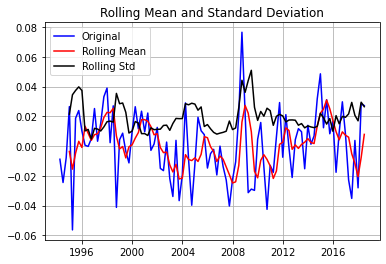

m2        
Test Statistic         -6.578831e+00
p-value                 7.604469e-09
Lags Used               1.000000e+00
Observations Used       9.600000e+01
Critical Value (1%)    -3.500379e+00
Critical Value (5%)    -2.892152e+00
Critical Value (10%)   -2.583100e+00
dtype: float64


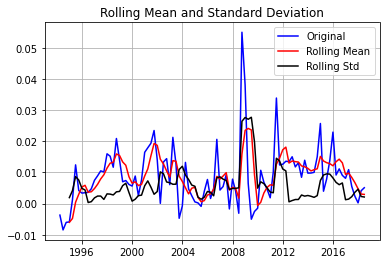

disp_inc  
Test Statistic         -1.313522e+01
p-value                 1.466900e-24
Lags Used               0.000000e+00
Observations Used       9.700000e+01
Critical Value (1%)    -3.499637e+00
Critical Value (5%)    -2.891831e+00
Critical Value (10%)   -2.582928e+00
dtype: float64


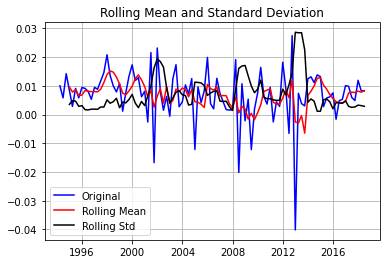

pce       
Test Statistic          -4.272805
p-value                  0.000495
Lags Used                1.000000
Observations Used       96.000000
Critical Value (1%)     -3.500379
Critical Value (5%)     -2.892152
Critical Value (10%)    -2.583100
dtype: float64


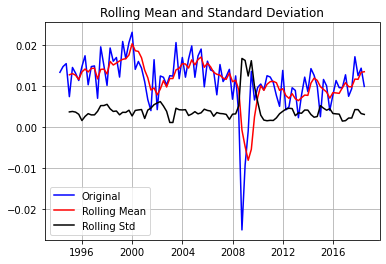

new_ord   
Test Statistic         -7.560725e+00
p-value                 3.015114e-11
Lags Used               0.000000e+00
Observations Used       9.700000e+01
Critical Value (1%)    -3.499637e+00
Critical Value (5%)    -2.891831e+00
Critical Value (10%)   -2.582928e+00
dtype: float64


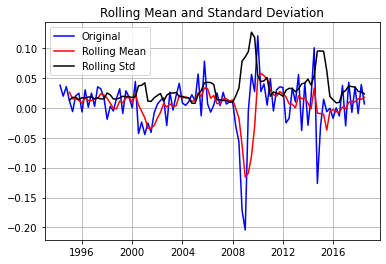

oil       
Test Statistic         -7.152863e+00
p-value                 3.108435e-10
Lags Used               1.000000e+00
Observations Used       9.600000e+01
Critical Value (1%)    -3.500379e+00
Critical Value (5%)    -2.892152e+00
Critical Value (10%)   -2.583100e+00
dtype: float64


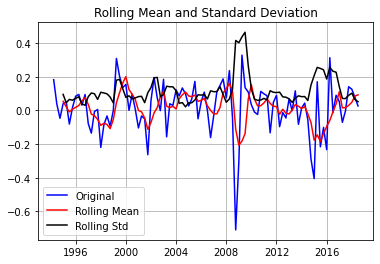

houst     
Test Statistic         -7.077799e+00
p-value                 4.751858e-10
Lags Used               0.000000e+00
Observations Used       9.700000e+01
Critical Value (1%)    -3.499637e+00
Critical Value (5%)    -2.891831e+00
Critical Value (10%)   -2.582928e+00
dtype: float64


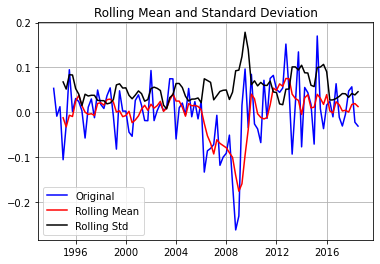

In [27]:
for i in df_train_log_diff:
    adf_test(df_train_log_diff[i], i)

After differencing our time-series we see that all our variables are now stationary.

### ACF and PACF of differenced series

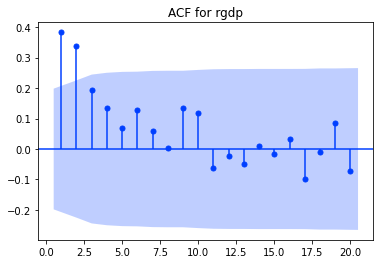

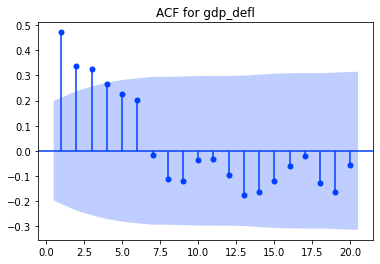

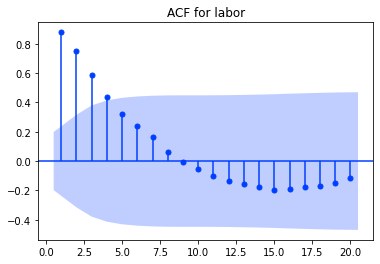

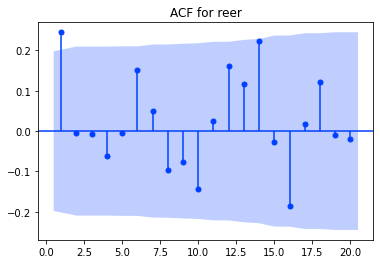

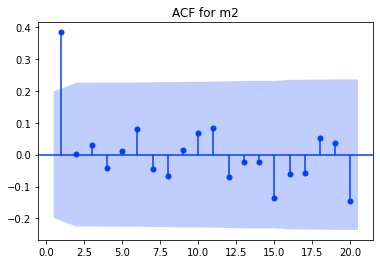

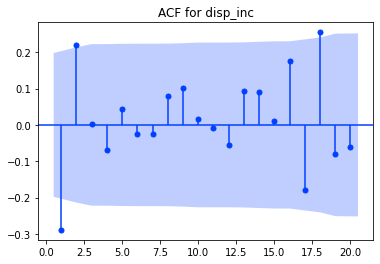

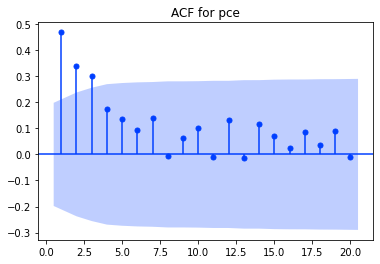

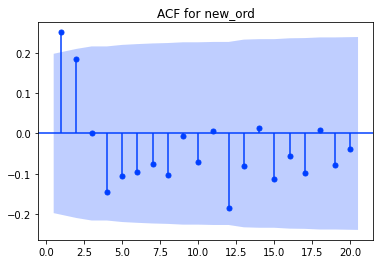

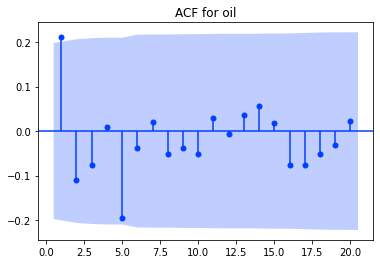

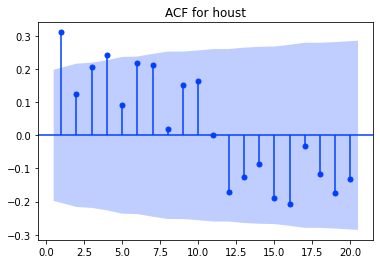

In [28]:
for i in df_train_log_diff:
    sgt.plot_acf(df_train_log_diff[i], lags = 20, zero=False)
    plt.title('ACF for %s' % i) 
    plt.show()

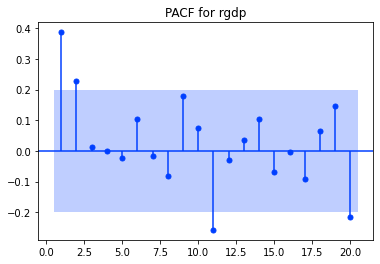

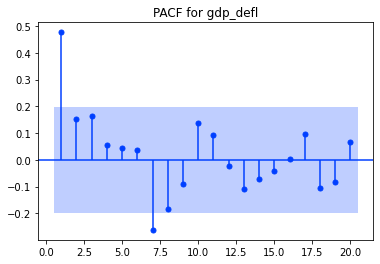

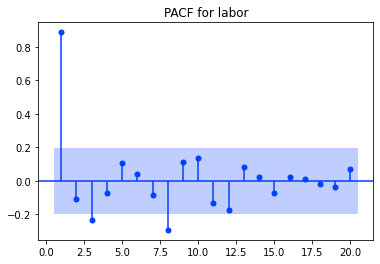

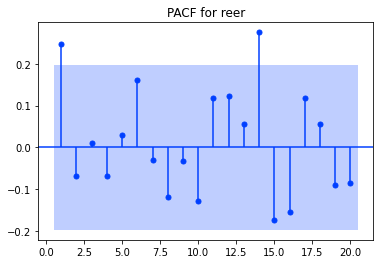

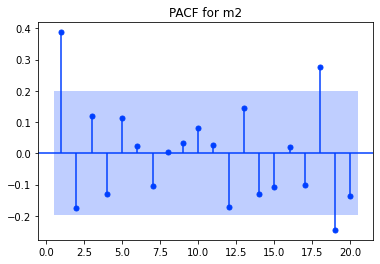

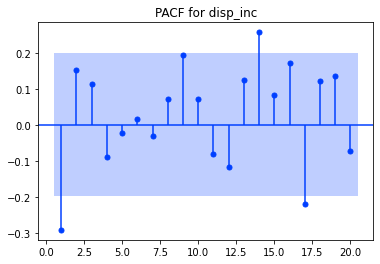

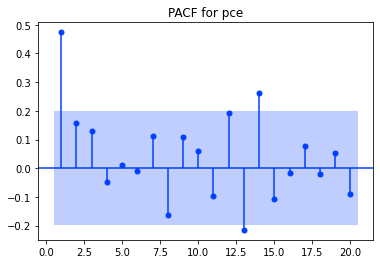

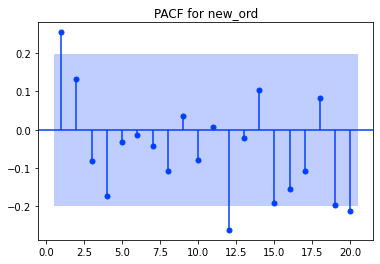

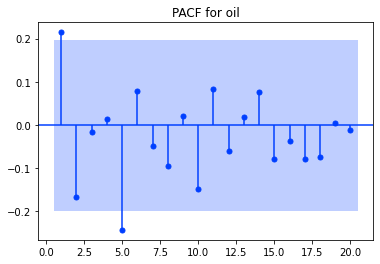

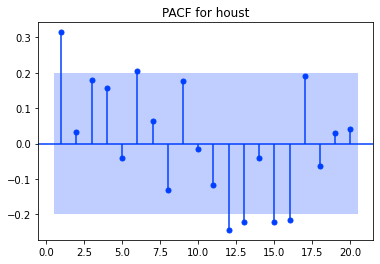

In [29]:
for i in df_train_log_diff:
    sgt.plot_pacf(df_train_log_diff[i], lags = 20, zero=False)
    plt.title('PACF for %s' % i) 
    plt.show()

Running the ACF and PACF plots now seems to indicate that only a few recent lags still seem to be significant.

## Granger's causality test

With Granger causality test we can assess the relationship between our variables even before creating any model. Specifically, the test help us to understand if a variable has explanatory power with respect to any other variable and vice versa.

We set max lags equal to 7 since, as a rule of thumb, p should never exceed:

(T/3) / n

where:

- T is the sample size
- n is the number of variables

In [30]:
lag = int(((int(len(df_train.index))) / 3) / int(len(df_train.columns)))
lag

3

In [31]:
maxlag=lag

test = 'ssr_chi2test'


def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = sts.grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [32]:
grangers_causation_matrix(df_train_log_diff, variables = df_train_log_diff.columns)

rgdp_x  gdp_defl_x  labor_x  reer_x    m2_x  disp_inc_x   pce_x  \
rgdp_y      1.0000      0.1608   0.0246  0.6910  0.3594      0.0068  0.0008   
gdp_defl_y  0.0009      1.0000   0.0147  0.0006  0.0034      0.0858  0.0049   
labor_y     0.0003      0.0184   1.0000  0.0004  0.0003      0.9307  0.0001   
reer_y      0.0500      0.2878   0.0994  1.0000  0.0474      0.4543  0.2502   
m2_y        0.0011      0.2493   0.1468  0.0506  1.0000      0.0039  0.0335   
disp_inc_y  0.0011      0.6691   0.0021  0.0509  0.2224      1.0000  0.0037   
pce_y       0.0002      0.0025   0.0257  0.0854  0.0883      0.0002  1.0000   
new_ord_y   0.0001      0.2841   0.0004  0.0011  0.0037      0.1156  0.0001   
oil_y       0.1699      0.0401   0.3168  0.0091  0.0585      0.1947  0.6277   
houst_y     0.1688      0.0074   0.5063  0.1165  0.0226      0.6110  0.0024   

            new_ord_x   oil_x  houst_x  
rgdp_y         0.0762  0.3908   0.0188  
gdp_defl_y     0.0032  0.0018   0.1879  
labor_y        0.0000  0.0012   0.0000  
reer_y         0.4158  0.1276   0.2815  
m2_y           0.0118  0.0654   0.1499  
disp_inc_y     0.0309  0.0512   0.4326  
pce_y          0.0094  0.0039   0.1591  
new_ord_y      1.0000  0.0016   0.0087  
oil_y          0.1308  1.0000   0.8902  
houst_y        0.0581  0.0276   1.0000

The row are the Response (Y) and the columns are the predictor series (X). For example, if you take the value 0.1608 in (row 1, column 2), it refers to the p-value of gdp_defl causing rgdp_y. If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). In that case, we can reject the null hypothesis.

We note that each variable cannot be a good predictor of all other variables: for example, the real effective exchange rate (reer_x) seems to have good explanatory power for the gdp_defl_y (p-value less than 0.05), but not for r_gdp_y (p-value greater than 0.05). Theoretically, we should keep only those variables that have the greatest explanatory power and drop those that are not highly significant, but, for our exercise, we will keep them all. In fact, we are specifically interested in predicting rgdp and gdp_defl, and it seems that all the other variables can explain at least one of the two.

## VAR model

### Lag order selection

In [33]:
#Initiate VAR model
var_model = VAR(endog=df_train_log_diff)
res_var = var_model.select_order(maxlags=3, trend='ct')
res_var.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

The table above shows for each lag we decided to include in our model (in this case we opted for 3 as our "maxlags" parameter) what is the associated information criterion: for example, the AIC is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. In short, we favour models with low information criteria. We notice that the AIC criterion indicates lag 1 as the best, while BIC another (but more parsimonious) information criterion indicates 0. For the sake of our model, we will stay with the lag indicated by the AIC (the most commonly used in econometrics), which is in agreement with other two criteria (FPE and HQIC).

### Fit the model

In [34]:
var_model_fit = var_model.fit(maxlags=1, ic='aic')
var_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Jan, 2022
Time:                     08:57:11
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -89.1863
Nobs:                     97.0000    HQIC:                  -90.9255
Log likelihood:           3200.77    FPE:                1.00714e-40
AIC:                     -92.1061    Det(Omega_mle):     3.44010e-41
--------------------------------------------------------------------
Results for equation rgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.002573         0.001883            1.367           0.172
L1.rgdp            -0.182786         0.129884           -1.407           0.159
L1.gdp_defl        -0.872502         0.269168           -3.241       

### Check for serial correlation of residuals

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series. So, checking for serial correlation is made to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

We can use the Durbin-Watson statistic for our purpose. The value of this statistic can vary between 0 and 4. The closer it is to the value 2, the lesser the likelihood of significant serial correlation. The more it is close to 0, the higher the chance of positive serial correlation, while the closer it is to 4 the higher the chance of negative serial correlation.

In [138]:
dw_check_var = durbin_watson(var_model_fit.resid)

for col, val in zip(df_train_log_diff.columns, dw_check_var):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
rgdp --> 1.96
----------------------------
Durbin-Watson statistic for:
gdp_defl --> 2.2
----------------------------
Durbin-Watson statistic for:
labor --> 2.23
----------------------------
Durbin-Watson statistic for:
reer --> 1.92
----------------------------
Durbin-Watson statistic for:
m2 --> 1.82
----------------------------
Durbin-Watson statistic for:
disp_inc --> 2.26
----------------------------
Durbin-Watson statistic for:
pce --> 1.99
----------------------------
Durbin-Watson statistic for:
new_ord --> 1.84
----------------------------
Durbin-Watson statistic for:
oil --> 1.96
----------------------------
Durbin-Watson statistic for:
houst --> 2.01
----------------------------


The Durbin-Watson test seems to indicate absence of serial correlation among residuals, as the values of the statistics lie around 2. A rule of thumb is that DW test statistic values in the range of 1.5 to 2.5 are relatively normal. 

### Making predictions

First, let's create a variable that contains the lag order from the model. We use the k_ar attribute of the results variable to extract it. We need to know this in order to provide the initial values necessary to make the first prediction.

In [36]:
#Get the lag order
lag_order = var_model_fit.k_ar
print(lag_order)

1


In [49]:
#Input data for forecasting
pred_input = df_train_log_diff.values[-lag_order:]
pred_input

array([[ 0.00480795,  0.00328758,  0.00382723,  0.02724057,  0.00510355,
         0.00823153,  0.00988977,  0.00638001,  0.02630133, -0.03096714]])

In [50]:
#Forecasting
var_pred = var_model_fit.forecast(y=pred_input, steps=len(df_test[start_date:end_date]))

df_var_pred = pd.DataFrame(var_pred, index = df_test[start_date:end_date].index, columns = df_train_log_diff.columns + '_1d')

df_var_pred.tail()

rgdp_1d  gdp_defl_1d  labor_1d   reer_1d     m2_1d  disp_inc_1d  \
2018-10-01  0.006443     0.003674  0.003621  0.003964  0.009401     0.008654   
2019-01-01  0.006672     0.004297  0.003411  0.002121  0.009107     0.006714   
2019-04-01  0.006868     0.004524  0.003467  0.001945  0.008997     0.007538   
2019-07-01  0.006700     0.004662  0.003419  0.001470  0.008690     0.007074   
2019-10-01  0.006586     0.004705  0.003349  0.001745  0.008835     0.007226   

              pce_1d  new_ord_1d    oil_1d  houst_1d  
2018-10-01  0.010815   -0.008424 -0.007856 -0.009772  
2019-01-01  0.011816    0.008055  0.011289  0.003977  
2019-04-01  0.011727    0.007727  0.018435  0.004990  
2019-07-01  0.011901    0.007723  0.018514  0.003291  
2019-10-01  0.011701    0.007270  0.015519  0.001594

### Invert transformations for comparison

In [39]:
# inverting transformation: single difference
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = np.log(df_train[col].iloc[-1]) + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [51]:
df_var_pred_inv = invert_transformation(df_train, df_var_pred)
df_var_pred_inv = df_var_pred_inv.filter(regex='_forecast$',axis=1)
df_var_pred_inv = np.exp(df_var_pred_inv) 

round(df_var_pred_inv.head(), 3)

rgdp_forecast  gdp_defl_forecast  labor_forecast  reer_forecast  \
2018-10-01      18800.332            111.004      149759.320        116.190   
2019-01-01      18926.191            111.482      150270.952        116.436   
2019-04-01      19056.626            111.988      150792.802        116.663   
2019-07-01      19184.734            112.511      151309.226        116.835   
2019-10-01      19311.510            113.041      151816.835        117.039   

            m2_forecast  disp_inc_forecast  pce_forecast  new_ord_forecast  \
2018-10-01     5691.152          14617.761     14154.862        240274.475   
2019-01-01     5743.220          14716.241     14323.111        242217.793   
2019-04-01     5795.123          14827.598     14492.063        244096.542   
2019-07-01     5845.700          14932.865     14665.560        245988.998   
2019-10-01     5897.576          15041.158     14838.165        247783.940   

            oil_forecast  houst_forecast  
2018-10-01        69.176        1227.941  
2019-01-01        69.962        1232.834  
2019-04-01        71.263        1239.001  
2019-07-01        72.595        1243.086  
2019-10-01        73.730        1245.069

### Evaluate the predictions

Before plotting our predictions against actual data, let's see how accurate our predictions were, looking at the MAPE (i.e., |actual-forecast| / |actual| * 100). Taking 1-MAPE, we obtain the accuracy of our prediction.

In [131]:
var_mape = metrics.mean_absolute_percentage_error(df_test_to_plot, df_var_pred_inv)

var_model_accuracy = 1 - var_mape
print("The accuracy of the VAR out-of-sample prediction is:")
print("----------------------------------------------------")
print(round(var_model_accuracy, 3))

The accuracy of the VAR out-of-sample prediction is:
----------------------------------------------------
0.965


The accuracy was quite high, but we need to remember that we have not taken into consideration the period when the Covid-19 hit the economy and therefore our economic variables.

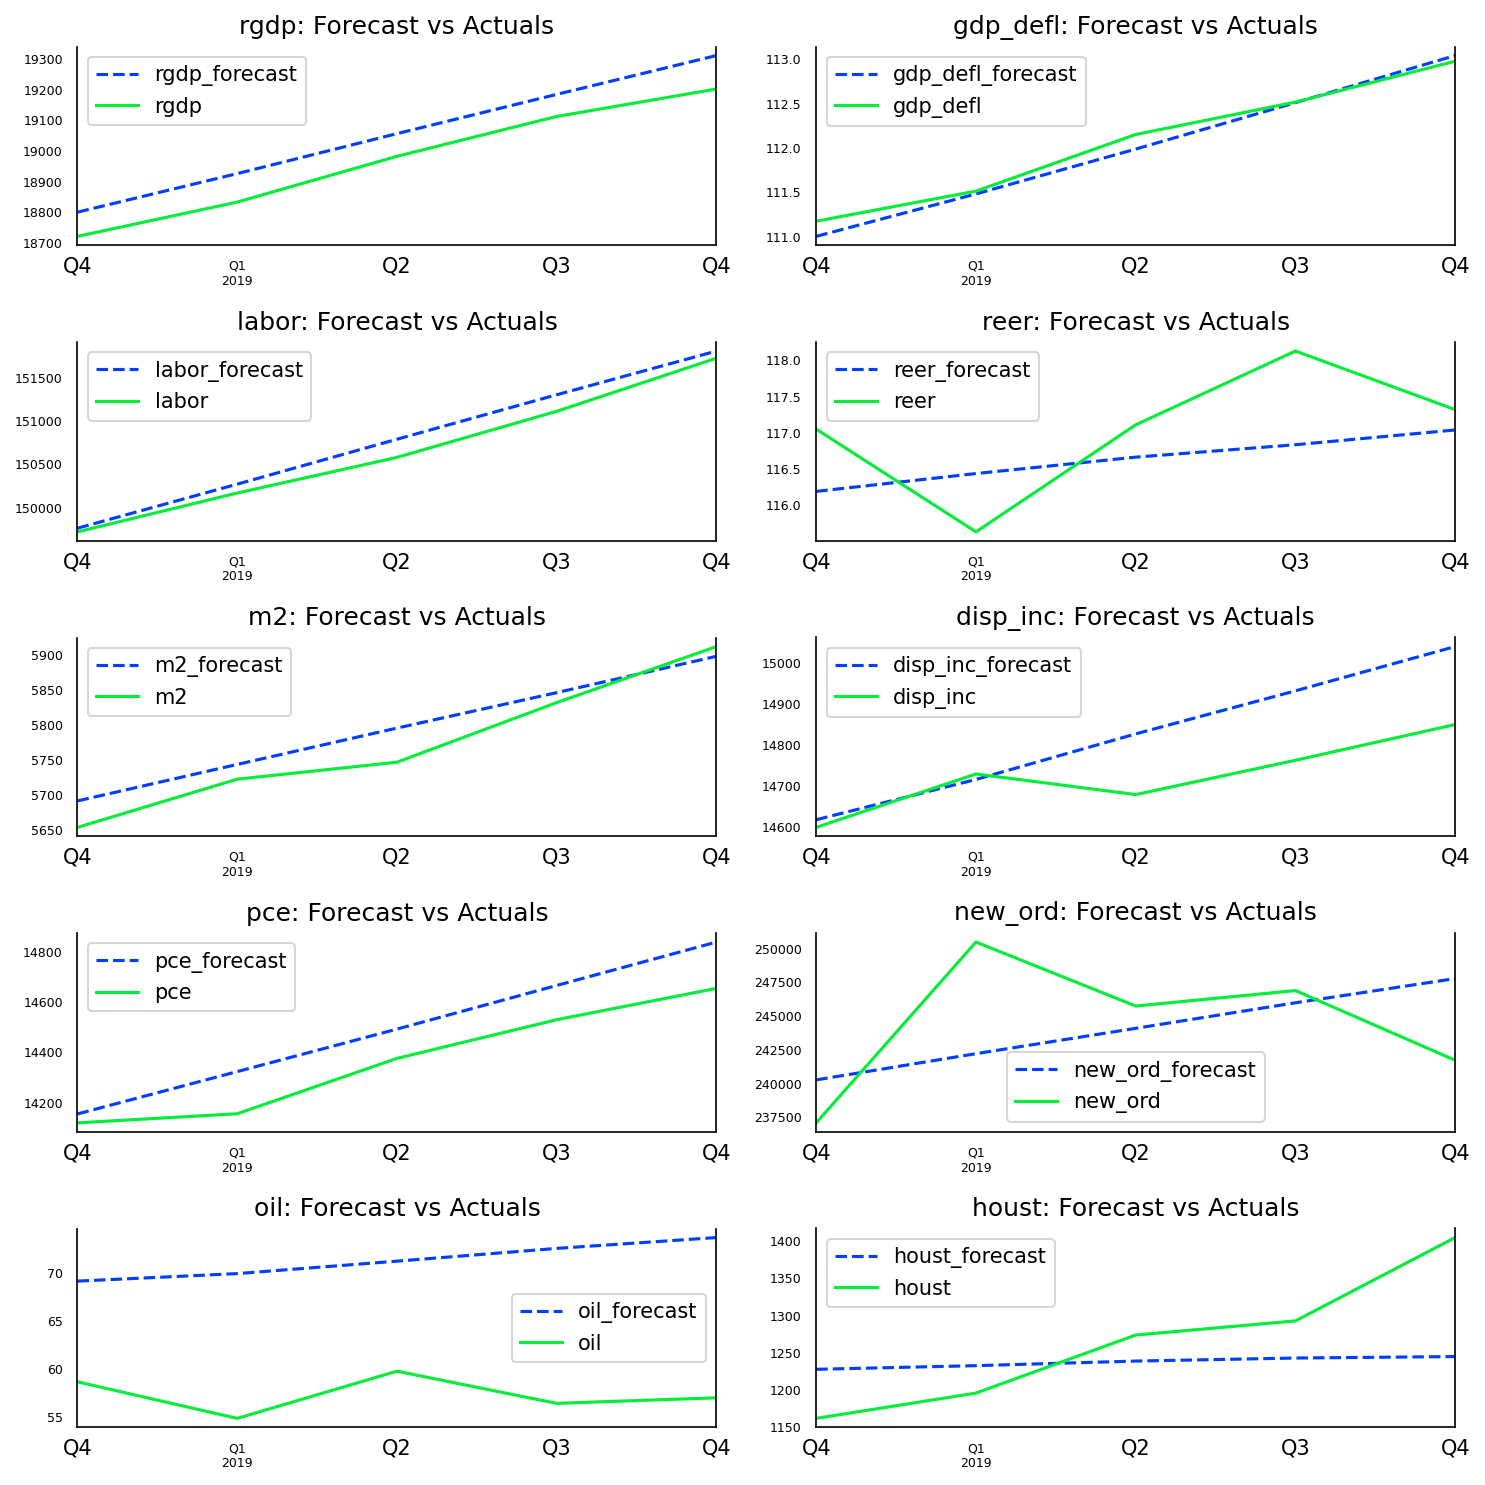

In [134]:
fig, axes = plt.subplots(nrows=int(len(df_test_to_plot.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_test_to_plot.columns, axes.flatten())):
    df_var_pred_inv[col+'_forecast'].plot(legend=True, ax=ax, linestyle='--').autoscale(axis='x',tight=True)
    df_test_to_plot[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

From the charts above we can have a better view of how our predictions behaved in the out-of-sample backtest. Despite some clear failures, as is the case for oil prices and housing starts, the other variables have been decently predicted.

## VECM model

Let's now move to our next model: the VECM model. This model can be applied only to variables that are cointegrated, i.e. variables that, if combined in a linear way, ended being stationary. Therefore, we need to perform a test that assess whether for each lag allowed there exist at least one combination of our variables that allows for stationarity. This model imposes additional restriction due to the existence of non-stationary but cointegrated data forms. The advantage of VECM over VAR is that the resulting VAR from VECM representation has more efficient coefficient estimates.

First, we need to determine the order of "p" for our cointegration test and to later build our VECM model. To do this, we build a simple VAR model with non-integrated variables and see what the optimal number of lags is. Then, we will take p-1 lags for our cointegration test and for our model.

In [44]:
#Initiate VAR model on variables levels to find optimal order "p"
var_model_levels = VAR(endog=df_train_log)
res_var_levels = var_model_levels.select_order(maxlags=3, trend='ct')
res_var_levels.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

This time, we see that the suggested number of lags by the AIC is 2. Therefore, for both the Johansen cointegration test and for our VECM model, we will use 2–1 lags.

### Johansen cointegration test

We perform the Johansen test for cointegration with (p-1) lags to check for cointegration.

In [46]:
def johansen_trace(y, p):
        N, l = y.shape
        joh_trace = coint_johansen(y, 0, p)
        r = 0
        for i in range(l):
            if joh_trace.lr1[i] > joh_trace.cvt[i, 1]:
                r = i + 1
        joh_trace.r = r
        return joh_trace

In [47]:
for i in range(1, 2): 
    # tests for cointegration at i lags
    joh_trace = johansen_trace(df_train_log, i)
    print('Using the Trace Test, there are', joh_trace.r, '''cointegrating vectors at 
    %s lags between the series''' % i)
    print()

Using the Trace Test, there are 8 cointegrating vectors at 
    1 lags between the series



In [45]:
j_test = coint_johansen(df_train_log,0,1)
print ('--------------------------------------------------')
print ('--> Trace Statistics')
print ('variable statistic Crit-90% Crit-95%  Crit-99%')
for i in range(len(j_test.lr1)):
    print ('r =', i, '\t', round(j_test.lr1[i], 4), j_test.cvt[i, 0], j_test.cvt[i, 1], j_test.cvt[i, 2])
print ('--------------------------------------------------')
print ('--> Eigen Statistics')
print ('variable statistic Crit-90% Crit-95%  Crit-99%')
for i in range(len(j_test.lr2)):
    print ('r =', i, '\t', round(j_test.lr2[i], 4), j_test.cvm[i, 0], j_test.cvm[i, 1], j_test.cvm[i, 2])

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 370.261 232.103 239.2468 253.2526
r = 1 	 290.4193 190.8714 197.3772 210.0366
r = 2 	 218.184 153.6341 159.529 171.0905
r = 3 	 159.9793 120.3673 125.6185 135.9825
r = 4 	 116.7034 91.109 95.7542 104.9637
r = 5 	 82.6398 65.8202 69.8189 77.8202
r = 6 	 55.5128 44.4929 47.8545 54.6815
r = 7 	 31.7904 27.0669 29.7961 35.4628
r = 8 	 12.0911 13.4294 15.4943 19.9349
r = 9 	 0.1994 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 79.8418 61.2041 64.504 71.2525
r = 1 	 72.2353 55.2412 58.4332 64.996
r = 2 	 58.2046 49.2855 52.3622 58.6634
r = 3 	 43.276 43.2947 46.2299 52.3069
r = 4 	 34.0636 37.2786 40.0763 45.8662
r = 5 	 27.127 31.2379 33.8777 39.3693
r = 6 	 23.7224 25.1236 27.5858 32.7172
r = 7 	 19.6993 18.8928 21.1314 25.865
r = 8 	 11.8917 12.2971 14.2639 18.52


### Fit the model

In [95]:
vecm_model = VECM(endog = df_train_log, k_ar_diff = 1, coint_rank = 8, deterministic = 'cili')
vecm_model_fit = vecm_model.fit()

In [135]:
vecm_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation rgdp
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.rgdp        -0.3529      0.134     -2.628      0.009      -0.616      -0.090
L1.gdp_defl    -1.2199      0.310     -3.941      0.000      -1.827      -0.613
L1.labor        0.4077      0.290      1.405      0.160      -0.161       0.976
L1.reer         0.0107      0.027      0.398      0.691      -0.042       0.063
L1.m2           0.2717      0.082      3.305      0.001       0.111       0.433
L1.disp_inc     0.1458      0.068      2.135      0.033       0.012       0.280
L1.pce          0.6210      0.141      4.396      0.000       0.344       0.898
L1.new_ord      0.0385      0.017      2.259      0.024       0.005       0.072
L1.oil          0.0059      0.005      1.252      0.210      -0.003       0.015
L1.houst        0.0070      0.009      0.807      0.420      -0.010       0.024
Det. terms outside the coint. relation & lagged endog. parameters for equation gdp_defl
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.rgdp         0.0830      0.049      1.703      0.089      -0.013       0.179
L1.gdp_defl     0.0736      0.112      0.655      0.512      -0.147       0.294
L1.labor        0.1115      0.105      1.059      0.290      -0.095       0.318
L1.reer        -0.0118      0.010     -1.212      0.226      -0.031       0.007
L1.m2          -0.0213      0.030     -0.716      0.474      -0.080       0.037
L1.disp_inc     0.0346      0.025      1.395      0.163      -0.014       0.083
L1.pce         -0.0860      0.051     -1.677      0.094      -0.186       0.015
L1.new_ord      0.0030      0.006      0.482      0.630      -0.009       0.015
L1.oil       3.606e-05      0.002      0.021      0.983      -0.003       0.003
L1.houst       -0.0023      0.003     -0.725      0.468      -0.009       0.004
Det. terms outside the coint. relation & lagged endog. parameters for equation labor
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.rgdp        -0.0883      0.042     -2.090      0.037      -0.171      -0.006
L1.gdp_defl    -0.2693      0.097     -2.766      0.006      -0.460      -0.078
L1.labor        0.3892      0.091      4.265      0.000       0.210       0.568
L1.reer        -0.0013      0.008     -0.159      0.874      -0.018       0.015
L1.m2           0.0280      0.026      1.083      0.279      -0.023       0.079
L1.disp_inc     0.0205      0.021      0.956      0.339      -0.022       0.063
L1.pce          0.1957      0.044      4.403      0.000       0.109       0.283
L1.new_ord      0.0103      0.005      1.926      0.054      -0.000       0.021
L1.oil          0.0027      0.001      1.804      0.071      -0.000       0.006
L1.houst        0.0031      0.003      1.127      0.260      -0.002       0.008
Det. terms outside the coint. relation & lagged endog. parameters for equation reer
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.rgdp        -0.9422      0.586     -1.607      0.108      -2.092       0.207
L1.gdp_defl     1.3992      1.352      1.035      0.301      -1.250       4.049
L1.labor       -0.5812      1.267     -0.459      0.646      -3.064       1.902
L1.reer    

### Check for serial correlation of residuals

In [137]:
dw_check_vecm = durbin_watson(vecm_model_fit.resid)

for col, val in zip(df_train_log.columns, dw_check_vecm):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
rgdp --> 2.22
----------------------------
Durbin-Watson statistic for:
gdp_defl --> 2.1
----------------------------
Durbin-Watson statistic for:
labor --> 2.2
----------------------------
Durbin-Watson statistic for:
reer --> 2.04
----------------------------
Durbin-Watson statistic for:
m2 --> 2.03
----------------------------
Durbin-Watson statistic for:
disp_inc --> 2.08
----------------------------
Durbin-Watson statistic for:
pce --> 2.13
----------------------------
Durbin-Watson statistic for:
new_ord --> 2.12
----------------------------
Durbin-Watson statistic for:
oil --> 1.97
----------------------------
Durbin-Watson statistic for:
houst --> 2.1
----------------------------


The Durbin-Watson check seems to indicate absence of serial correlation among residuals, as the values of the statistics lie around 2.

### Making predictions

In [63]:
vecm_pred = vecm_model_fit.predict(steps=len(df_test[start_date:end_date]))

In [64]:
df_vecm_pred = pd.DataFrame(vecm_pred, 
                           index=df_test[start_date:end_date].index, 
                           columns=df_train.columns + '_forecast')


### Invert transformation for comparison

In [65]:
df_vecm_pred_inv = np.exp(df_vecm_pred)
df_vecm_pred_inv.head()

rgdp_forecast  gdp_defl_forecast  labor_forecast  reer_forecast  \
2018-10-01   18804.294599         111.075266   149731.512247     116.229192   
2019-01-01   18935.420724         111.535093   150263.121660     117.470443   
2019-04-01   19088.859244         111.999181   150888.068138     118.493936   
2019-07-01   19241.038286         112.467099   151598.525830     118.945205   
2019-10-01   19400.155887         112.961999   152385.162017     119.261941   

            m2_forecast  disp_inc_forecast  pce_forecast  new_ord_forecast  \
2018-10-01  5709.281574       14522.006051  14168.947166     241761.810985   
2019-01-01  5796.832567       14644.720819  14316.838849     247059.870760   
2019-04-01  5870.683179       14754.325744  14492.614726     248653.482996   
2019-07-01  5942.745870       14876.233696  14668.883109     252893.851146   
2019-10-01  6011.466462       14990.436472  14861.529331     256415.881115   

            oil_forecast  houst_forecast  
2018-10-01     65.100533     1296.772642  
2019-01-01     59.815447     1371.550751  
2019-04-01     57.896132     1433.007547  
2019-07-01     56.229324     1493.894881  
2019-10-01     55.654800     1546.981622

### Evaluate the predictions

In [139]:
vecm_mape = metrics.mean_absolute_percentage_error(df_test_to_plot, df_vecm_pred_inv)
vecm_model_accuracy = 1 - vecm_mape

print("The accuracy of the VECM out-of-sample prediction is:")
print("----------------------------------------------------")
print(round(vecm_model_accuracy, 3))

The accuracy of the VECM out-of-sample prediction is:
----------------------------------------------------
0.974


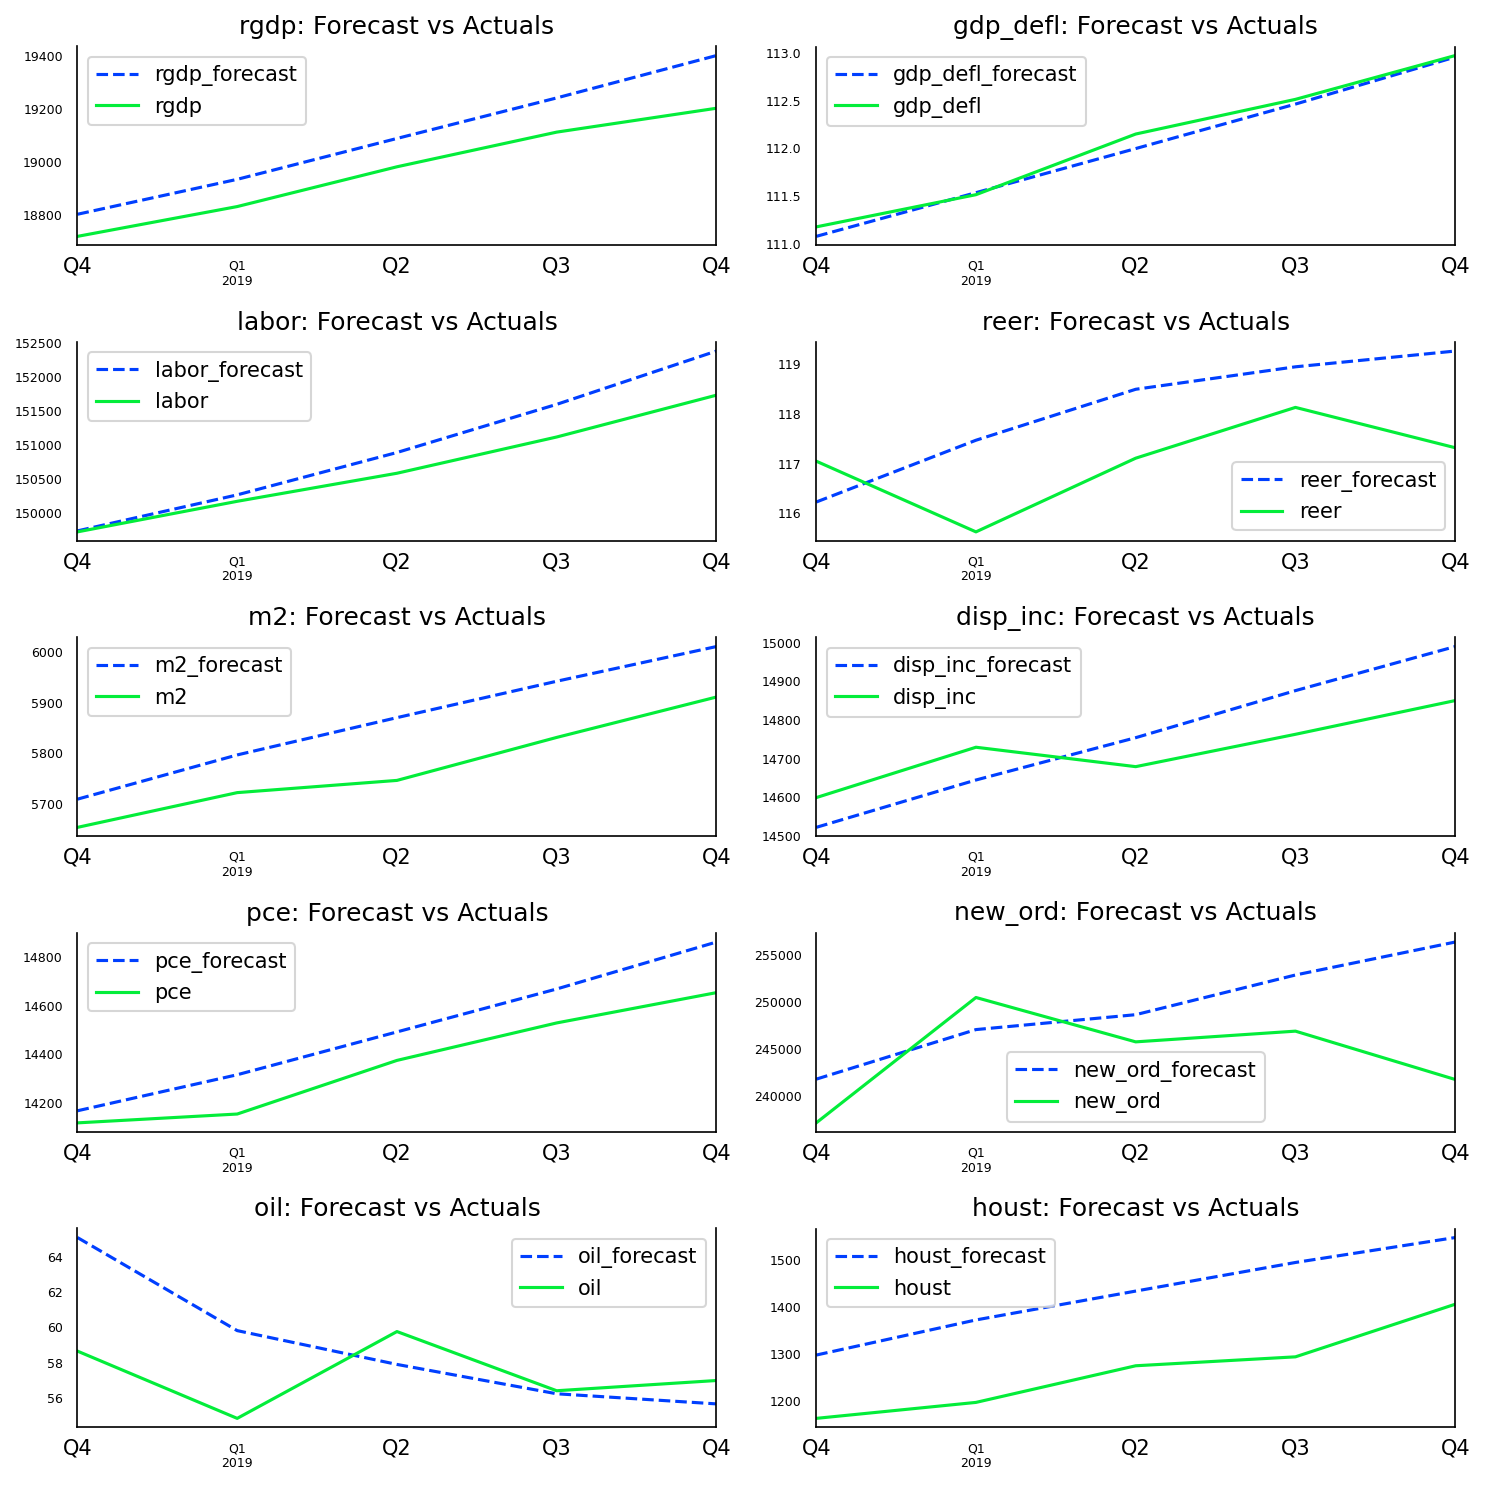

In [140]:
fig, axes = plt.subplots(nrows=int(len(df_test_to_plot.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_test_to_plot.columns, axes.flatten())):
    df_vecm_pred_inv[col+'_forecast'].plot(legend=True, ax=ax, linestyle="--").autoscale(axis='x',tight=True)
    df_test_to_plot[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

We note that the model slightly improved compared to a traditional VAR. Let's see if using a more complex model we improve our results.

## VARMA model

### Finding otpimal hyper-parameters

The VARMAX model adds a moving average component to the VAR model, and it can allow for external, or exogenous, variables as well. It must be noted that the VARMAX model does not have a seasonal component. This is not necessarily a problem, as seasonality can be included through the exogenous variables.

Since there is no easy way to estimate the best parameters p and q for our VARMA model, we need to create a for loop which iterates through all possible combinations of hyperparameters and then select the optimal ones. We allow for a model with a max of 3 lags for each p and q (since we follow the rule of thumb already discussed in the VAR section for finding max p). We will also assess each combination of trend hyperparameter and see which combination gives us back the lowest AIC value.

In [380]:
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [382]:
df_fitted_VARMA = pd.DataFrame(columns=['p', 
                                         'q', 
                                         'tr',
                                         'AIC'])

for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(df_train_log_diff, order=(p,q), trend=tr, initialization='approximate_diffuse').fit(maxiter=30)
    aic = model.aic
    
    df_fitted_VARMA = df_fitted_VARMA.append({'p': p, 'q': q, 'tr': tr, 'AIC':aic}, ignore_index=True)

In [384]:
df_fitted_VARMA.sort_values(by=['AIC']).head()

p  q  tr          AIC
1   1  1   c -5560.167200
13  2  1   c -5458.226368
14  2  1   t -5453.589304
7   1  2  ct -5232.306344
24  3  1   n -5207.782202

From the table above, we see that our best models can be a 1,1 or a 2,1 VARMA model with a constant.

### Fit the model

We can mechanically select the first combination that returns the lowest AIC value, but we will also test the following two and see if the accuracy of our predictions decreases or improves.

In [68]:
varma_model = VARMAX(endog=df_train_log_diff, order=(2,1), trend='t')
varma_model_fit = varma_model.fit(maxiter=1000, disp=False)

varma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                               Statespace Model Results                                                              
=====================================================================================================================================================
Dep. Variable:     ['rgdp', 'gdp_defl', 'labor', 'reer', 'm2', 'disp_inc', 'pce', 'new_ord', 'oil', 'houst']   No. Observations:                   98
Model:                                                                                            VARMA(2,1)   Log Likelihood                3308.089
                                                                                                 + intercept   AIC                          -5886.177
Date:                                                                                       Wed, 26 Jan 2022   BIC                          -4942.664
Time:                                                                                               09:32:59   HQIC                         -5504.546
Sample:                                                                                           04-01-1994                                         
                                                                                                - 07-01-2018                                         
Covariance Type:                                                                                         opg                                         
===========================================================================================================================================================================
Ljung-Box (L1) (Q):     0.50, 0.37, 0.00, 0.01, 0.04, 0.04, 0.00, 0.00, 0.02, 0.00   Jarque-Bera (JB):         2.67, 3.89, 5.32, 3.53, 23.25, 36.28, 0.33, 4.19, 3.57, 2.16
Prob(Q):                0.48, 0.54, 0.98, 0.93, 0.84, 0.85, 0.96, 0.99, 0.88, 0.95   Prob(JB):                   0.26, 0.14, 0.07, 0.17, 0.00, 0.00, 0.85, 0.12, 0.17, 0.34
Heteroskedasticity (H): 0.69, 3.52, 1.30, 1.10, 1.01, 2.53, 0.65, 1.84, 0.68, 1.47   Skew:               -0.30, -0.20, -0.53, -0.46, 0.97, -0.27, -0.07, -0.21, -0.44, 0.32
Prob(H) (two-sided):    0.30, 0.00, 0.46, 0.79, 0.98, 0.01, 0.23, 0.08, 0.27, 0.27   Kurtosis:                   3.54, 3.89, 3.44, 3.15, 4.40, 5.93, 3.25, 3.92, 3.32, 2.65
                            Results for equation rgdp                             
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift           -1.36e-05   3.61e-05     -0.377      0.706   -8.44e-05    5.72e-05
L1.rgdp           -0.2154      0.005    -44.123      0.000      -0.225      -0.206
L1.gdp_defl       -0.9953      0.002   -474.053      0.000      -0.999      -0.991
L1.labor           0.2961      0.003     91.412      0.000       0.290       0.302
L1.reer           -0.0045      0.014     -0.329      0.742      -0.031       0.022
L1.m2              0.1134      0.006     19.175      0.000       0.102       0.125
L1.disp_inc        0.0483      0.008      6.059      0.000       0.033       0.064
L1.pce             0.6297      0.007     86.332      0.000       0.615       0.644
L1.new_ord         0.0271      0.014      1.967      0.049       0.000       0.054
L1.oil             0.0003      0.011      0.025      0.980      -0.022       0.022
L1.houst           0.0100      0.013      0.746      0.456      -0.016       0.036
L2.rgdp            0.0327      0.007      4.977      0.000       0.020       0.046
L2.gdp_defl        0.4415      0.002    185.855      0.000       0.437       0.446
L2.labor          -0.1414      0.004    -37.426      0.000      -0.149      -0.134
L2.reer            0.0080      0.014      0.577      0.564      -0.019       0.035
L2.m2          

### Check for serial correlation of residuals

In [142]:
dw_check_varma = durbin_watson(varma_model_fit.resid)

for col, val in zip(df_train_log_diff.columns, dw_check_varma):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
rgdp --> 2.03
----------------------------
Durbin-Watson statistic for:
gdp_defl --> 1.95
----------------------------
Durbin-Watson statistic for:
labor --> 1.62
----------------------------
Durbin-Watson statistic for:
reer --> 1.96
----------------------------
Durbin-Watson statistic for:
m2 --> 1.99
----------------------------
Durbin-Watson statistic for:
disp_inc --> 1.92
----------------------------
Durbin-Watson statistic for:
pce --> 1.89
----------------------------
Durbin-Watson statistic for:
new_ord --> 2.1
----------------------------
Durbin-Watson statistic for:
oil --> 2.01
----------------------------
Durbin-Watson statistic for:
houst --> 2.01
----------------------------


The Durbin-Watson check seems to indicate absence of serial correlation among residuals, as the values of the statistics lie around 2.

### Making predictions

In [69]:
varma_pred = varma_model_fit.forecast(steps=len(df_test[start_date:end_date]))
df_varma_pred = pd.DataFrame(varma_pred.values, 
                             index=df_test[start_date:end_date].index, 
                             columns=df_train_log_diff.columns + '_1d')

### Invert transformation for comparison

In [71]:
df_varma_pred_inv = invert_transformation(df_train, df_varma_pred)
df_varma_pred_inv = df_varma_pred_inv.filter(regex='_forecast$',axis=1)
df_varma_pred_inv = np.exp(df_varma_pred_inv)
df_varma_pred_inv.head()

rgdp_forecast  gdp_defl_forecast  labor_forecast  reer_forecast  \
2018-10-01   18806.634290         111.159654   149814.740978     116.144208   
2019-01-01   18899.331865         111.724347   150140.757673     117.271867   
2019-04-01   18992.935187         112.337792   150549.146760     117.752753   
2019-07-01   19099.078255         112.941082   150943.014605     118.265525   
2019-10-01   19217.548659         113.575028   151418.210783     118.521629   

            m2_forecast  disp_inc_forecast  pce_forecast  new_ord_forecast  \
2018-10-01  5731.460829       14729.439847  14179.937603     238125.660228   
2019-01-01  5818.736935       14845.128997  14316.553468     235624.858957   
2019-04-01  5902.452772       14960.297143  14481.794360     232381.291911   
2019-07-01  5982.263363       15057.323679  14645.226380     234581.656076   
2019-10-01  6060.683979       15169.410957  14821.968437     235533.683834   

            oil_forecast  houst_forecast  
2018-10-01     61.555087     1165.388013  
2019-01-01     56.505067     1177.282121  
2019-04-01     54.721631     1159.403703  
2019-07-01     54.862412     1181.879161  
2019-10-01     55.227487     1192.560206

### Evaluate the predictions

In [141]:
varma_mape = metrics.mean_absolute_percentage_error(df_test_to_plot, df_varma_pred_inv)
varma_model_accuracy = 1 - varma_mape

print("The accuracy of the VARMA out-of-sample prediction is:")
print("----------------------------------------------------")
print(round(varma_model_accuracy, 3))

The accuracy of the VARMA out-of-sample prediction is:
----------------------------------------------------
0.979


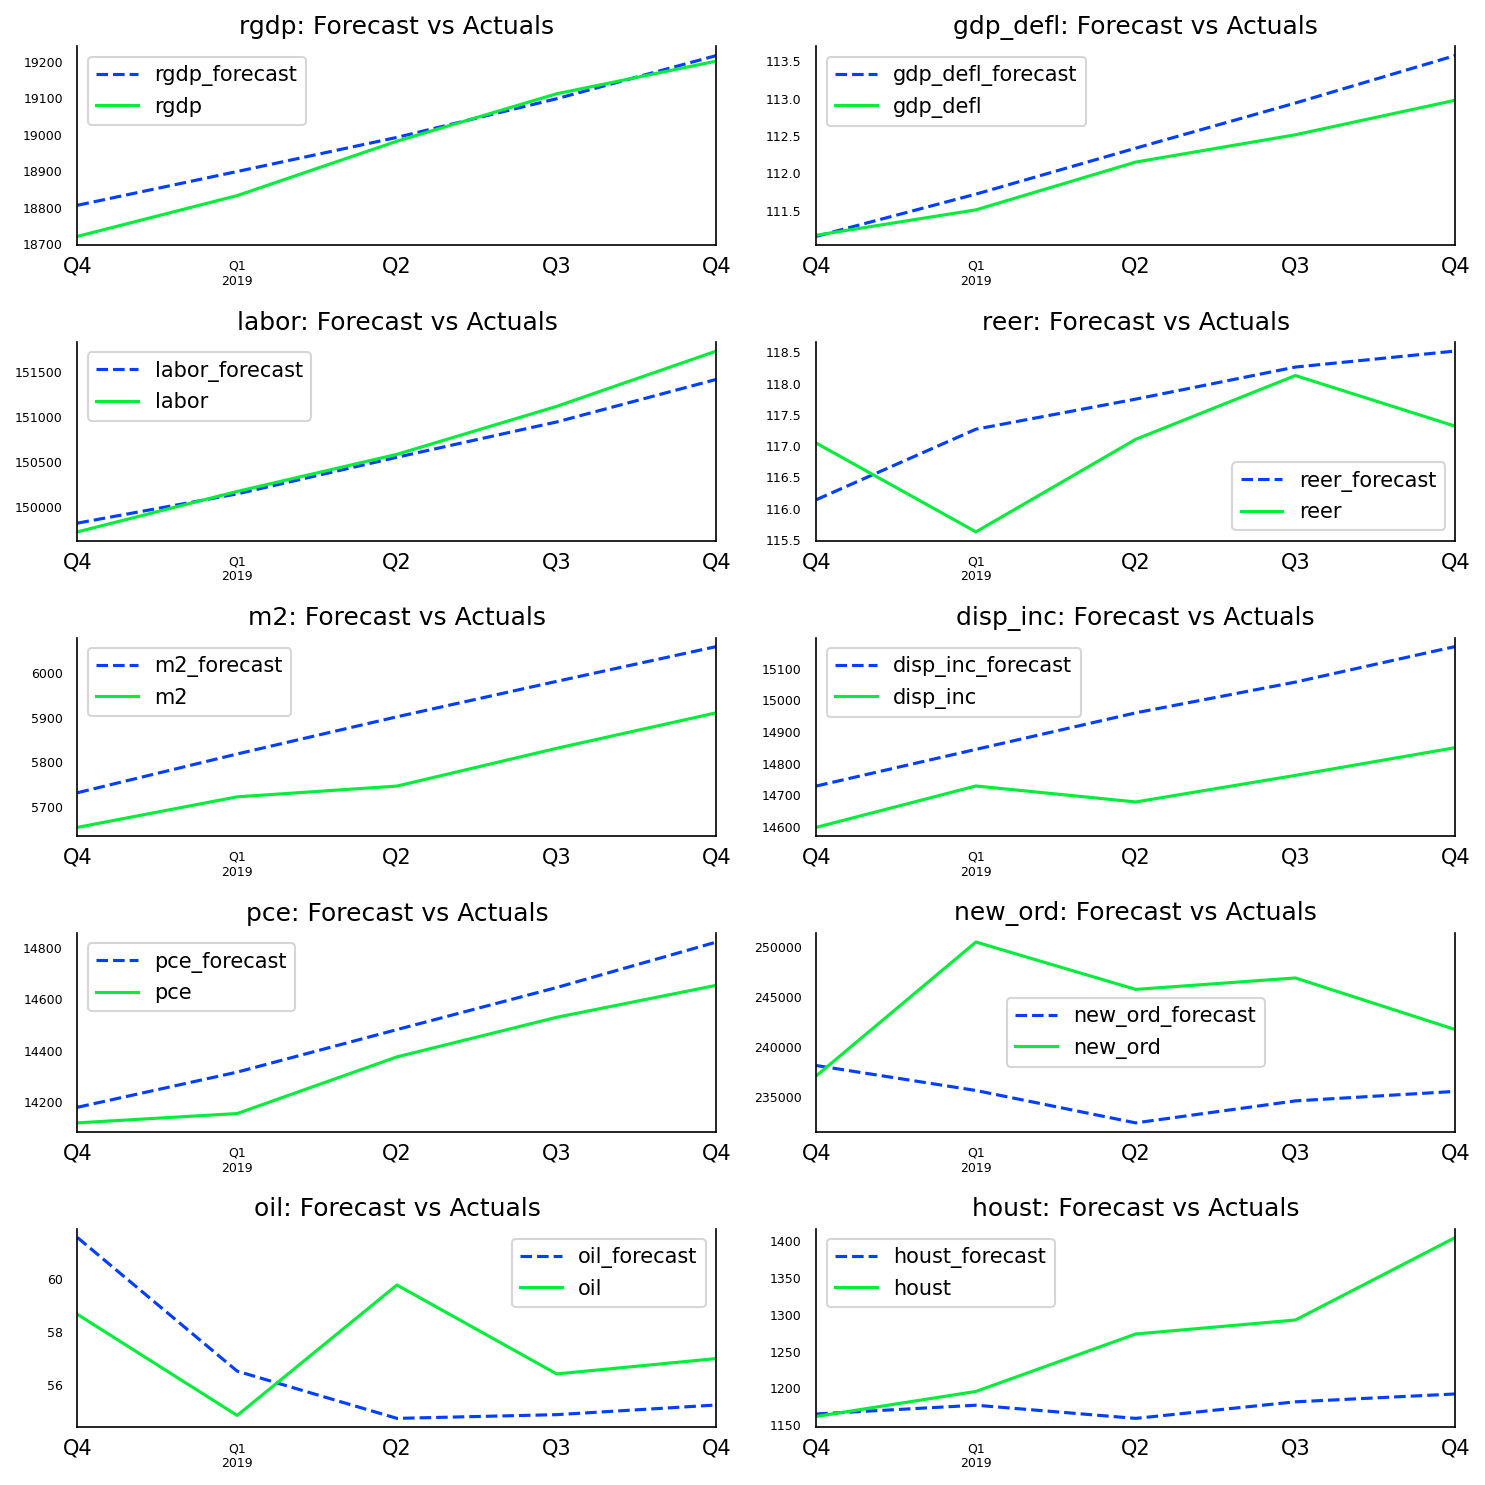

In [143]:
fig, axes = plt.subplots(nrows=int(len(df_test_to_plot.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_test_to_plot.columns, axes.flatten())):
    df_varma_pred_inv[col+'_forecast'].plot(legend=True, ax=ax, linestyle="--").autoscale(axis='x',tight=True)
    df_test_to_plot[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

After running the top three combinations of hyper-parameters, we decide to stick with the third one, which has the highest results in terms of forecasting ability. Our VARMA model seems to have further improved the prediction ability compared to our previous models.

In [144]:
print("VAR model accuracy is: " + str(var_model_accuracy))
print("-----------------------------------------------------")
print("VECM model accuracy is: " + str(vecm_model_accuracy))
print("-----------------------------------------------------")
print("VARMA model accuracy is: " + str(varma_model_accuracy))

VAR model accuracy is: 0.9651015029156635
-----------------------------------------------------
VECM model accuracy is: 0.9740550961531286
-----------------------------------------------------
VARMA model accuracy is: 0.9788724530455992


## Forecasting four quarters ahead

The difference between making predictions and making forecasts is that predictions are comparable against an hold-out set, as was the case for our test set before. On the other hand, when forecasting we cannot verify the performance of our results, because we do not have any actual data for comparison yet.

Let's now see what values our models forecast for the future four quarters ahead. Therefore, we define our forecasting window as the next four quarters for which we do not have actual data.

### Defining the forecasting horizon

In [76]:
fc_window = ['2021-10-01', '2022-01-01', '2022-04-01', '2022-07-01']

### Data transformation

As we have already done for our training set, we apply the natural log to our entire series and the integrate it once in order to make them stationary.

In [78]:
df_log = np.log(df)
df_log_diff = df_log.diff().dropna()

### Stationarity check

rgdp      
Test Statistic         -1.218836e+01
p-value                 1.302913e-22
Lags Used               0.000000e+00
Observations Used       1.090000e+02
Critical Value (1%)    -3.491818e+00
Critical Value (5%)    -2.888444e+00
Critical Value (10%)   -2.581120e+00
dtype: float64


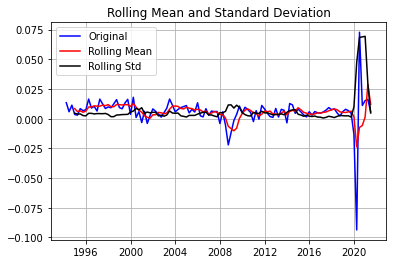

gdp_defl  
Test Statistic           -3.135816
p-value                   0.024014
Lags Used                 1.000000
Observations Used       108.000000
Critical Value (1%)      -3.492401
Critical Value (5%)      -2.888697
Critical Value (10%)     -2.581255
dtype: float64


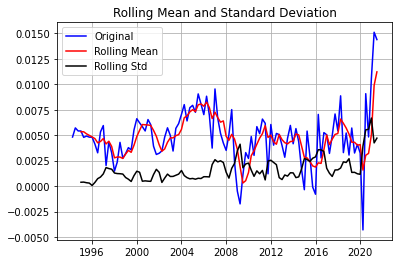

labor     
Test Statistic         -1.239921e+01
p-value                 4.601271e-23
Lags Used               0.000000e+00
Observations Used       1.090000e+02
Critical Value (1%)    -3.491818e+00
Critical Value (5%)    -2.888444e+00
Critical Value (10%)   -2.581120e+00
dtype: float64


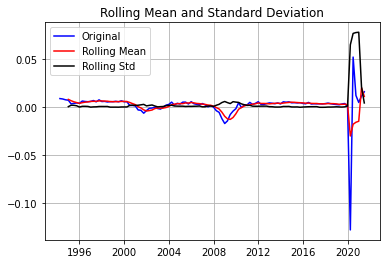

reer      
Test Statistic         -8.096803e+00
p-value                 1.332315e-12
Lags Used               0.000000e+00
Observations Used       1.090000e+02
Critical Value (1%)    -3.491818e+00
Critical Value (5%)    -2.888444e+00
Critical Value (10%)   -2.581120e+00
dtype: float64


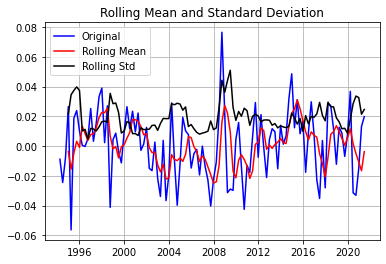

m2        
Test Statistic         -7.525393e+00
p-value                 3.696402e-11
Lags Used               0.000000e+00
Observations Used       1.090000e+02
Critical Value (1%)    -3.491818e+00
Critical Value (5%)    -2.888444e+00
Critical Value (10%)   -2.581120e+00
dtype: float64


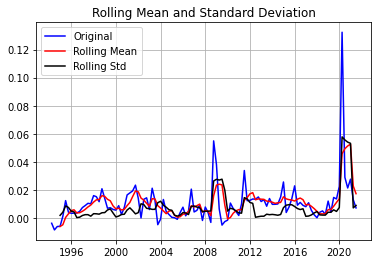

disp_inc  
Test Statistic           -5.480358
p-value                   0.000002
Lags Used                 2.000000
Observations Used       107.000000
Critical Value (1%)      -3.492996
Critical Value (5%)      -2.888955
Critical Value (10%)     -2.581393
dtype: float64


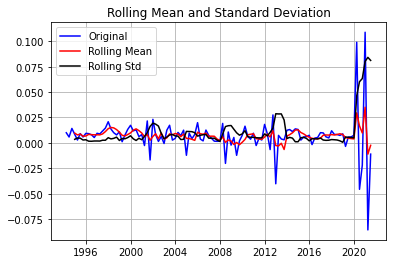

pce       
Test Statistic         -1.192107e+01
p-value                 5.030938e-22
Lags Used               0.000000e+00
Observations Used       1.090000e+02
Critical Value (1%)    -3.491818e+00
Critical Value (5%)    -2.888444e+00
Critical Value (10%)   -2.581120e+00
dtype: float64


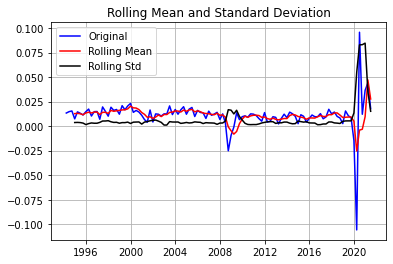

new_ord   
Test Statistic         -8.859647e+00
p-value                 1.494888e-14
Lags Used               0.000000e+00
Observations Used       1.090000e+02
Critical Value (1%)    -3.491818e+00
Critical Value (5%)    -2.888444e+00
Critical Value (10%)   -2.581120e+00
dtype: float64


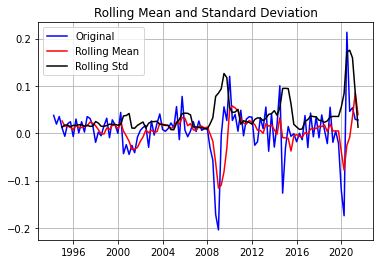

oil       
Test Statistic         -8.814470e+00
p-value                 1.951159e-14
Lags Used               0.000000e+00
Observations Used       1.090000e+02
Critical Value (1%)    -3.491818e+00
Critical Value (5%)    -2.888444e+00
Critical Value (10%)   -2.581120e+00
dtype: float64


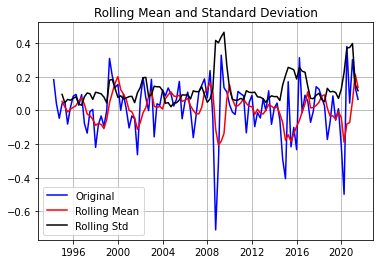

houst     
Test Statistic         -9.268742e+00
p-value                 1.344654e-15
Lags Used               0.000000e+00
Observations Used       1.090000e+02
Critical Value (1%)    -3.491818e+00
Critical Value (5%)    -2.888444e+00
Critical Value (10%)   -2.581120e+00
dtype: float64


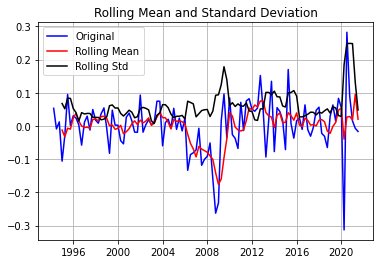

In [79]:
for i in df_log_diff:
    adf_test(df_log_diff[i], i)

From the ADF test, it seems all our variables are stationary after applying the first difference.

### Making actual forecasts with VAR

We already know the optimal p order of our trained VAR model, i.e. 1 lag. Nevertheless, out of curiosity we decide to run again the select_order method on the entire dataset and see if we obtain a different result. We apply the rule of thumb for the maxlags parameter as we did before. 

In [80]:
lag_fc = int(((int(len(df.index))) / 3) / int(len(df.columns)))
lag_fc

3

In [81]:
#Initiate VAR model
var_model_fc = VAR(endog=df_log_diff)
res_var_fc = var_model_fc.select_order(maxlags=lag_fc, trend='ct')
res_var_fc.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

Interestingly, after applying the "select_order" method, we note that the lowest AIC would be achieved with a 2-lag order. This should be due to the inclusion of extreme observations linked to the Covid-19 pandemic shock, which altered our parameters estimation. Since we have already tested our model under normal conditions (i.e. excluding the Covid-19 shock and opting for a 1-lag model), we'll move on with the pre-selected number of lags for our VAR model. This may not be the best choice, but we want to be coherent with our initial choice to exclude the Covid-19 impact. 

In [82]:
#Fitting the model
var_model_fc_fit = var_model_fc.fit(maxlags=1, ic='aic')
var_model_fc_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Jan, 2022
Time:                     10:21:02
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -83.2465
Nobs:                     109.000    HQIC:                  -84.8611
Log likelihood:           3248.32    FPE:                4.67656e-38
AIC:                     -85.9626    Det(Omega_mle):     1.78805e-38
--------------------------------------------------------------------
Results for equation rgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001970         0.002791            0.706           0.480
L1.rgdp             0.056515         0.274996            0.206           0.837
L1.gdp_defl        -0.772840         0.528300           -1.463       

In [145]:
#Checking for auto-correlation of residuals
dw_check_var_fc = durbin_watson(var_model_fc_fit.resid)

for col, val in zip(df_train_log_diff.columns, dw_check_var_fc):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
rgdp --> 2.04
----------------------------
Durbin-Watson statistic for:
gdp_defl --> 2.3
----------------------------
Durbin-Watson statistic for:
labor --> 2.08
----------------------------
Durbin-Watson statistic for:
reer --> 1.94
----------------------------
Durbin-Watson statistic for:
m2 --> 1.99
----------------------------
Durbin-Watson statistic for:
disp_inc --> 1.82
----------------------------
Durbin-Watson statistic for:
pce --> 1.98
----------------------------
Durbin-Watson statistic for:
new_ord --> 1.88
----------------------------
Durbin-Watson statistic for:
oil --> 1.97
----------------------------
Durbin-Watson statistic for:
houst --> 1.93
----------------------------


From the residual auto-correlation check it seems that everything is ok, so we can move on with our forecast. 

In [85]:
#Get the lag order
lag_order_fc = var_model_fc_fit.k_ar
print(lag_order_fc)

1


In [86]:
#Input data for forecasting
fc_input = df_log_diff.values[-lag_order_fc:]
fc_input

array([[ 0.00569324,  0.01439178,  0.01630822,  0.01982824,  0.00724755,
        -0.01103072,  0.0179044 ,  0.02809782,  0.06567754, -0.01650831]])

In [87]:
#Making forecasts
var_fc = var_model_fc_fit.forecast(y=fc_input, steps=int(len(fc_window)))

df_var_fc = pd.DataFrame(var_fc, index = fc_window, columns = df_log_diff.columns + '_1d')

df_var_fc.tail()

rgdp_1d  gdp_defl_1d  labor_1d   reer_1d     m2_1d  disp_inc_1d  \
2021-10-01 -0.009384     0.008499 -0.005946  0.021647  0.027505     0.019419   
2022-01-01  0.000831     0.006607 -0.002518  0.013231  0.026441     0.002874   
2022-04-01  0.006221     0.005807  0.003009  0.004066  0.019291     0.002339   
2022-07-01  0.005102     0.005345  0.001885  0.001605  0.016486     0.006262   

              pce_1d  new_ord_1d    oil_1d  houst_1d  
2021-10-01 -0.001563   -0.055334 -0.122275 -0.105497  
2022-01-01  0.009159   -0.028069 -0.056415 -0.049815  
2022-04-01  0.013078   -0.000423  0.006268 -0.003132  
2022-07-01  0.011401    0.002216  0.018257  0.002455

In [88]:
#Un-transform our series to reflect actual values 
df_var_fc_inv = invert_transformation(df, df_var_fc)
df_var_fc_inv = df_var_fc_inv.filter(regex='_forecast$',axis=1)
df_var_fc_inv = np.exp(df_var_fc_inv) 

round(df_var_fc_inv.head(), 3)

rgdp_forecast  gdp_defl_forecast  labor_forecast  reer_forecast  \
2021-10-01      19296.962            120.132      146566.848        119.714   
2022-01-01      19313.000            120.928      146198.325        121.308   
2022-04-01      19433.526            121.632      146638.945        121.802   
2022-07-01      19532.939            122.284      146915.561        121.998   

            m2_forecast  disp_inc_forecast  pce_forecast  new_ord_forecast  \
2021-10-01     7828.695          15939.750     15940.058        246797.864   
2022-01-01     8038.454          15985.629     16086.732        239966.821   
2022-04-01     8195.027          16023.059     16298.497        239865.269   
2022-07-01     8331.246          16123.714     16485.387        240397.302   

            oil_forecast  houst_forecast  
2021-10-01        62.465        1405.608  
2022-01-01        59.039        1337.303  
2022-04-01        59.410        1333.121  
2022-07-01        60.505        1336.398

In [89]:
#First, we create a copy of our forecast data set
df_var_fc_plot = df_var_fc_inv.copy()

#Let's remove the "_forecast" suffix from our columns names
df_var_fc_plot.columns = df_var_fc_plot.columns.str[:-9]

#Let's now append the forecasts into our original dataframe for plotting
var_fc_plot = df.append(df_var_fc_plot)
var_fc_plot.index = pd.to_datetime(var_fc_plot.index)
var_fc_plot.tail(8)

rgdp    gdp_defl          labor        reer           m2  \
2020-10-01  18767.778000  114.439000  142619.000000  115.050000  7259.100000   
2021-01-01  19055.655000  115.652000  143355.000000  113.340000  7462.900000   
2021-04-01  19368.310000  117.413000  145056.000000  114.850000  7561.300000   
2021-07-01  19478.893000  119.115000  147441.000000  117.150000  7616.300000   
2021-10-01  19296.961979  120.131614  146566.848280  119.713586  7828.695146   
2022-01-01  19313.000186  120.927956  146198.325016  121.307985  8038.454043   
2022-04-01  19433.526435  121.632210  146638.945001  121.802234  8195.026630   
2022-07-01  19532.938786  122.284029  146915.561315  121.997846  8331.245935   

                disp_inc           pce        new_ord        oil        houst  
2020-10-01  15442.900000  14467.600000  233367.000000  42.713216  1575.000000  
2021-01-01  17218.800000  15005.500000  246296.000000  57.790333  1599.000000  
2021-04-01  15806.600000  15681.700000  253612.000000  66.102648  1588.000000  
2021-07-01  15633.200000  15965.000000  260839.000000  70.589848  1562.000000  
2021-10-01  15939.749679  15940.058229  246797.863663  62.465304  1405.608319  
2022-01-01  15985.629459  16086.731560  239966.820675  59.038911  1337.302842  
2022-04-01  16023.059455  16298.497346  239865.269174  59.410136  1333.121418  
2022-07-01  16123.713524  16485.387052  240397.301524  60.504741  1336.397805

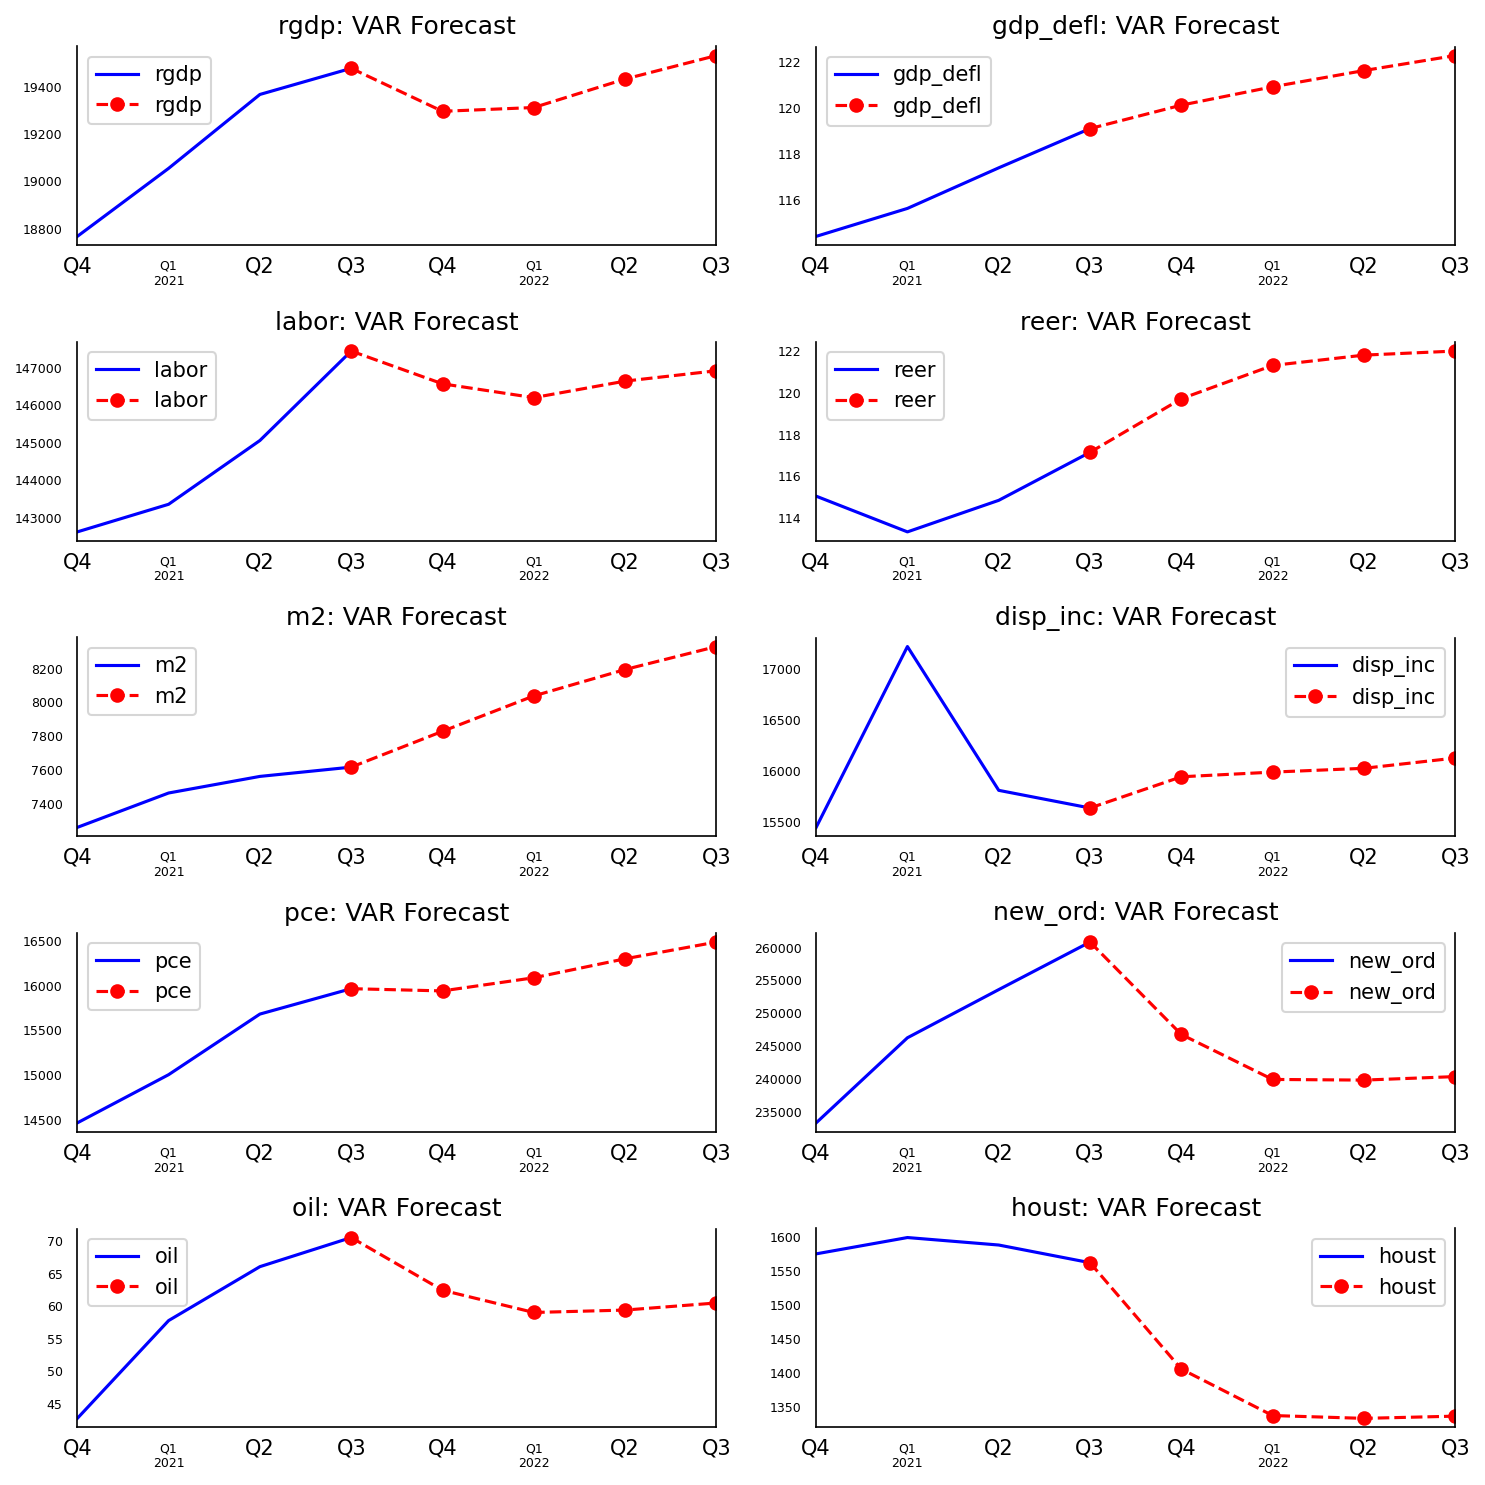

In [90]:
#Plotting our VAR forecasts
fig, axes = plt.subplots(nrows=int(len(var_fc_plot.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(var_fc_plot.columns, axes.flatten())):
    var_fc_plot[col].iloc[-8:-4].plot(legend=True, ax=ax, color='b')
    var_fc_plot[col].iloc[-5:].plot(legend=True, ax=ax, marker='o', color='r', linestyle='--');
    ax.set_title(col + ": VAR Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Making actual forecasts with VECM

Let's see if the lag selection and cointegration test give us back different results than our trained model.

In [100]:
#Initiate VAR model on variables levels to find optimal order "p"
var_model_levels_fc = VAR(endog=df_log)
res_var_levels_fc = var_model_levels_fc.select_order(maxlags=3, trend='ct')
res_var_levels_fc.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [102]:
#Running the Johansen cointegration test
j_test_fc = coint_johansen(df_log,0,2)
print ('--------------------------------------------------')
print ('--> Trace Statistics')
print ('variable statistic Crit-90% Crit-95%  Crit-99%')
for i in range(len(j_test.lr1)):
    print ('r =', i, '\t', round(j_test.lr1[i], 4), j_test.cvt[i, 0], j_test.cvt[i, 1], j_test.cvt[i, 2])
print ('--------------------------------------------------')
print ('--> Eigen Statistics')
print ('variable statistic Crit-90% Crit-95%  Crit-99%')
for i in range(len(j_test.lr2)):
    print ('r =', i, '\t', round(j_test.lr2[i], 4), j_test.cvm[i, 0], j_test.cvm[i, 1], j_test.cvm[i, 2])

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 333.4802 232.103 239.2468 253.2526
r = 1 	 251.9155 190.8714 197.3772 210.0366
r = 2 	 191.5865 153.6341 159.529 171.0905
r = 3 	 143.7047 120.3673 125.6185 135.9825
r = 4 	 100.6238 91.109 95.7542 104.9637
r = 5 	 69.1998 65.8202 69.8189 77.8202
r = 6 	 47.3887 44.4929 47.8545 54.6815
r = 7 	 26.9537 27.0669 29.7961 35.4628
r = 8 	 7.921 13.4294 15.4943 19.9349
r = 9 	 0.3187 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 81.5647 61.2041 64.504 71.2525
r = 1 	 60.329 55.2412 58.4332 64.996
r = 2 	 47.8818 49.2855 52.3622 58.6634
r = 3 	 43.0809 43.2947 46.2299 52.3069
r = 4 	 31.4241 37.2786 40.0763 45.8662
r = 5 	 21.811 31.2379 33.8777 39.3693
r = 6 	 20.435 25.1236 27.5858 32.7172
r = 7 	 19.0327 18.8928 21.1314 25.865
r = 8 	 7.6023 12.2971 14.2639 18.52
r 

Once again, we note that fitting the model to our complete data set would lead to different hyperparameters. In this case, the cointegration test suggest to use a rank order of 7 for p-1 equal to 2 instead of 1, as was the case for our trained model. Again, we decide to stick with our trained model parameters and accept the possibility of underestimating uncertainty.

In [109]:
#Fitting the model
vecm_model_fc = VECM(endog = df_log, k_ar_diff = 1, coint_rank = 8, deterministic = 'cili')
vecm_model_fc_fit = vecm_model_fc.fit()

In [146]:
#Checking for residual auto-correlation
dw_check_vecm_fc = durbin_watson(vecm_model_fc_fit.resid)

for col, val in zip(df_train_log.columns, dw_check_vecm_fc):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
rgdp --> 2.01
----------------------------
Durbin-Watson statistic for:
gdp_defl --> 2.02
----------------------------
Durbin-Watson statistic for:
labor --> 2.06
----------------------------
Durbin-Watson statistic for:
reer --> 2.01
----------------------------
Durbin-Watson statistic for:
m2 --> 1.94
----------------------------
Durbin-Watson statistic for:
disp_inc --> 1.89
----------------------------
Durbin-Watson statistic for:
pce --> 1.86
----------------------------
Durbin-Watson statistic for:
new_ord --> 1.91
----------------------------
Durbin-Watson statistic for:
oil --> 1.9
----------------------------
Durbin-Watson statistic for:
houst --> 1.92
----------------------------


From the residual auto-correlation check it seems that everything is ok, so we can move on with our forecast.

In [111]:
#Making forecasts
vecm_fc = vecm_model_fc_fit.predict(steps=int(len(fc_window)))

In [112]:
#Converting forecasts in a dataframe
df_vecm_fc = pd.DataFrame(vecm_fc, 
                           index=fc_window, 
                           columns=df_log.columns + '_forecast')

In [113]:
#Transforming back forecasts to their original scale
df_vecm_fc_inv = np.exp(df_vecm_fc)
df_vecm_fc_inv.head()

rgdp_forecast  gdp_defl_forecast  labor_forecast  reer_forecast  \
2021-10-01   19483.090925         120.318827   148375.192292     115.562609   
2022-01-01   19734.314567         121.573601   150918.233841     112.543911   
2022-04-01   19808.620441         122.701124   152557.380429     110.351058   
2022-07-01   19754.375641         123.658707   152933.462535     108.420224   

            m2_forecast  disp_inc_forecast  pce_forecast  new_ord_forecast  \
2021-10-01  7624.047490       15923.591204  16255.945453     251598.015906   
2022-01-01  7514.488856       15693.679683  16741.981456     251641.051014   
2022-04-01  7367.692980       15597.426994  17002.108964     245219.760886   
2022-07-01  7220.353026       15532.478737  17134.034710     233512.817266   

            oil_forecast  houst_forecast  
2021-10-01     76.025926     1344.806804  
2022-01-01     81.846201     1196.488304  
2022-04-01     86.284714     1014.795899  
2022-07-01     90.724528      823.271939

In [114]:
#First, we create a copy of our forecast data set
df_vecm_fc_plot = df_vecm_fc_inv.copy()

#Let's remove the "_forecast" suffix from our columns names
df_vecm_fc_plot.columns = df_vecm_fc_plot.columns.str[:-9]

#Let's now append the forecasts into our original dataframe for plotting
vecm_fc_plot = df.append(df_vecm_fc_plot)
vecm_fc_plot.index = pd.to_datetime(vecm_fc_plot.index)
vecm_fc_plot.tail(8)

rgdp    gdp_defl          labor        reer           m2  \
2020-10-01  18767.778000  114.439000  142619.000000  115.050000  7259.100000   
2021-01-01  19055.655000  115.652000  143355.000000  113.340000  7462.900000   
2021-04-01  19368.310000  117.413000  145056.000000  114.850000  7561.300000   
2021-07-01  19478.893000  119.115000  147441.000000  117.150000  7616.300000   
2021-10-01  19483.090925  120.318827  148375.192292  115.562609  7624.047490   
2022-01-01  19734.314567  121.573601  150918.233841  112.543911  7514.488856   
2022-04-01  19808.620441  122.701124  152557.380429  110.351058  7367.692980   
2022-07-01  19754.375641  123.658707  152933.462535  108.420224  7220.353026   

                disp_inc           pce        new_ord        oil        houst  
2020-10-01  15442.900000  14467.600000  233367.000000  42.713216  1575.000000  
2021-01-01  17218.800000  15005.500000  246296.000000  57.790333  1599.000000  
2021-04-01  15806.600000  15681.700000  253612.000000  66.102648  1588.000000  
2021-07-01  15633.200000  15965.000000  260839.000000  70.589848  1562.000000  
2021-10-01  15923.591204  16255.945453  251598.015906  76.025926  1344.806804  
2022-01-01  15693.679683  16741.981456  251641.051014  81.846201  1196.488304  
2022-04-01  15597.426994  17002.108964  245219.760886  86.284714  1014.795899  
2022-07-01  15532.478737  17134.034710  233512.817266  90.724528   823.271939

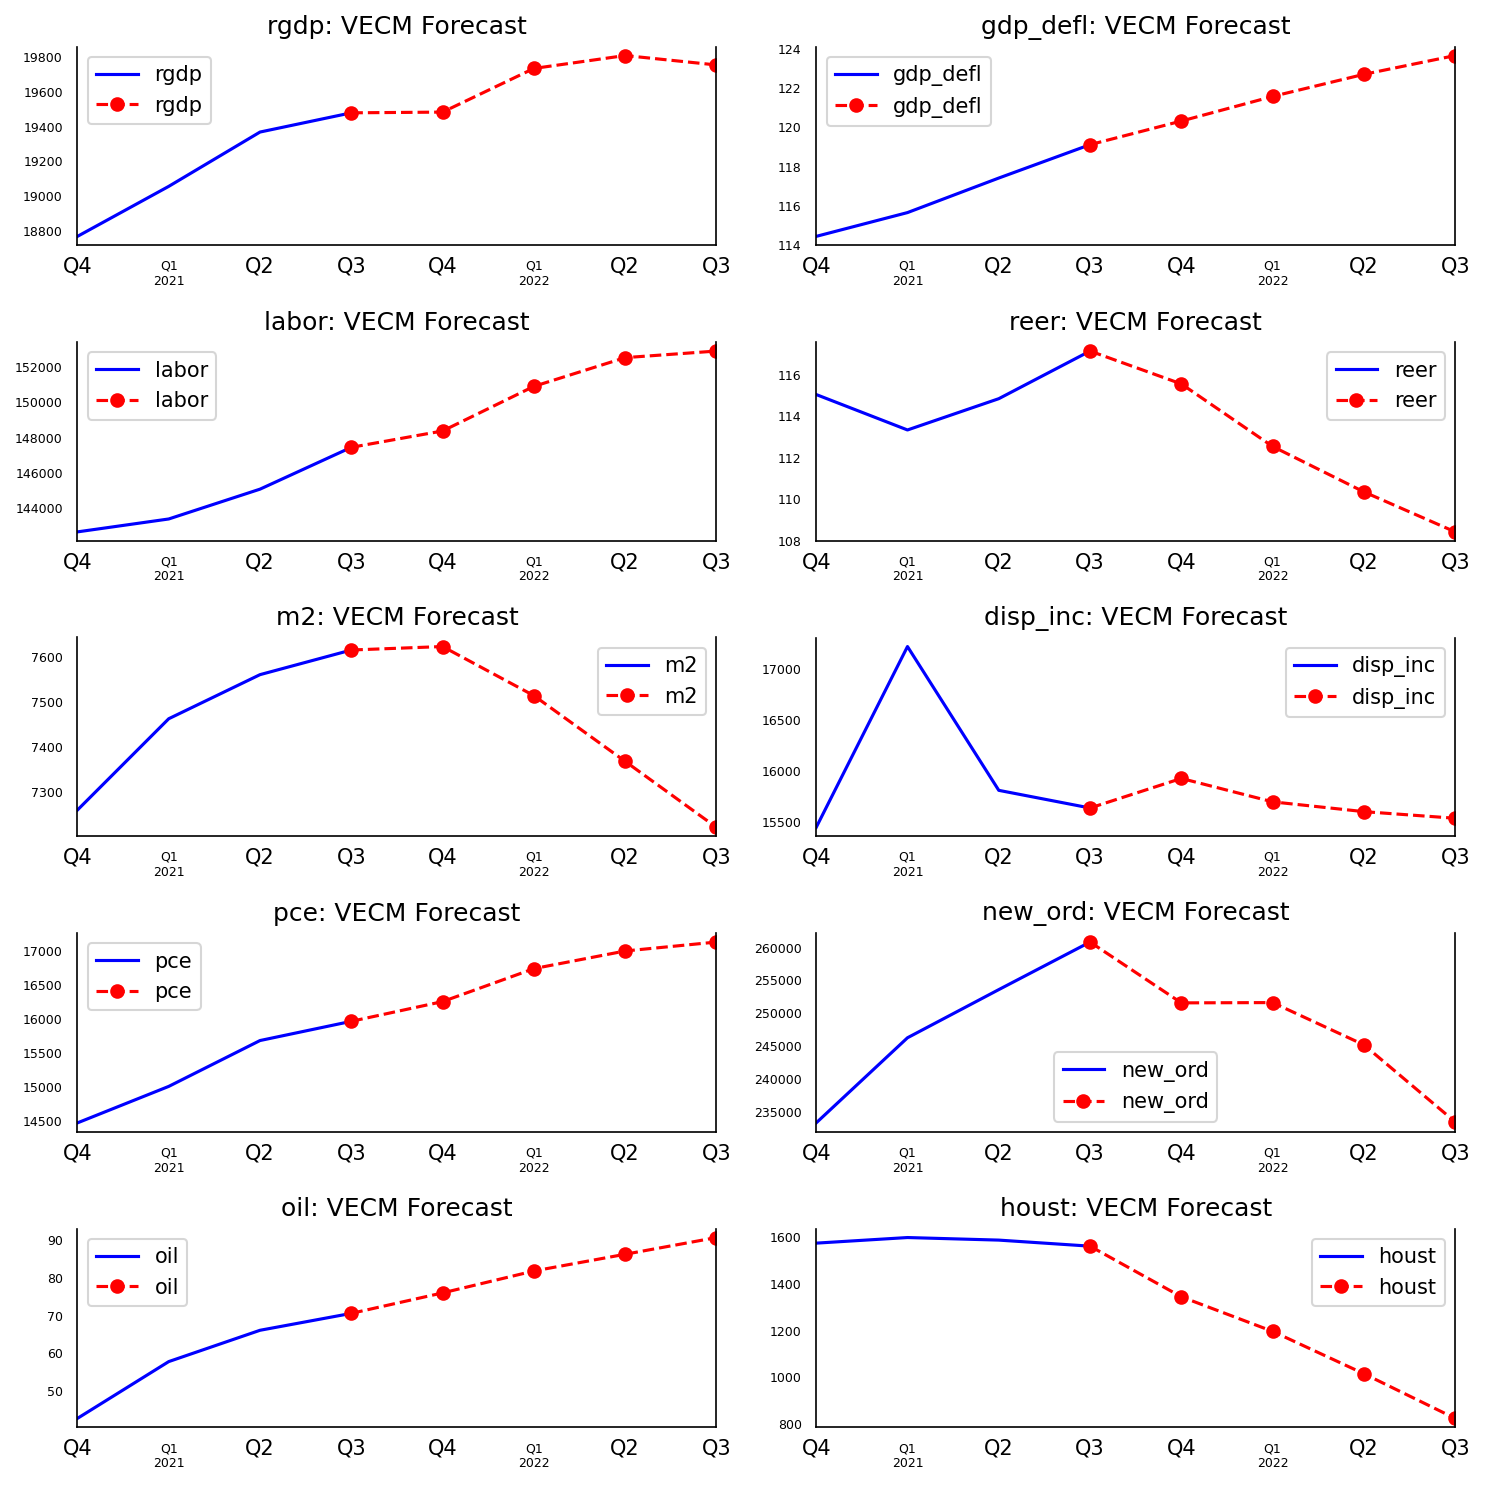

In [115]:
#Plotting our forecasts
fig, axes = plt.subplots(nrows=int(len(vecm_fc_plot.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(vecm_fc_plot.columns, axes.flatten())):
    vecm_fc_plot[col].iloc[-8:-4].plot(legend=True, ax=ax, color='b')
    vecm_fc_plot[col].iloc[-5:].plot(legend=True, ax=ax, marker='o', color='r', linestyle='--');
    ax.set_title(col + ": VECM Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

### Making actual forecasts with VARMA

For VARMA forecasts we won't go through all the parameters estimation once again, since this requires lots of time and computation memory. Furthermore, we want to stick with our previously trained model for making actual forecasts.

In [116]:
#Let's fit the model with the parameters already found
varma_model_fc = VARMAX(endog=df_log_diff, order=(2,1), trend='t')
varma_model_fc_fit = varma_model_fc.fit(maxiter=1000, disp=False)

varma_model_fc_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                               Statespace Model Results                                                              
=====================================================================================================================================================
Dep. Variable:     ['rgdp', 'gdp_defl', 'labor', 'reer', 'm2', 'disp_inc', 'pce', 'new_ord', 'oil', 'houst']   No. Observations:                  110
Model:                                                                                            VARMA(2,1)   Log Likelihood                3388.866
                                                                                                 + intercept   AIC                          -6047.732
Date:                                                                                       Wed, 26 Jan 2022   BIC                          -5062.057
Time:                                                                                               11:20:50   HQIC                         -5647.937
Sample:                                                                                           04-01-1994                                         
                                                                                                - 07-01-2021                                         
Covariance Type:                                                                                         opg                                         
===========================================================================================================================================================================
Ljung-Box (L1) (Q):     0.01, 0.01, 0.09, 0.00, 0.02, 0.00, 0.00, 0.00, 0.01, 0.01   Jarque-Bera (JB):     443.94, 2.13, 46.89, 2.86, 26.08, 32.69, 12.29, 0.90, 4.99, 0.25
Prob(Q):                0.94, 0.93, 0.77, 0.97, 0.90, 0.98, 1.00, 0.95, 0.94, 0.94   Prob(JB):                   0.00, 0.34, 0.00, 0.24, 0.00, 0.00, 0.00, 0.64, 0.08, 0.88
Heteroskedasticity (H): 2.70, 2.53, 2.15, 0.97, 0.74, 1.92, 1.00, 2.71, 0.66, 1.93   Skew:               -1.89, -0.02, 0.04, -0.28, 0.70, -0.86, -0.44, -0.16, -0.47, -0.03
Prob(H) (two-sided):    0.00, 0.01, 0.02, 0.93, 0.36, 0.05, 1.00, 0.00, 0.21, 0.05   Kurtosis:                  12.09, 3.68, 6.20, 3.56, 4.93, 5.04, 4.38, 3.31, 3.46, 2.77
                            Results for equation rgdp                             
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift          -4.354e-05   7.26e-05     -0.600      0.549      -0.000    9.87e-05
L1.rgdp           -0.0213      0.013     -1.657      0.098      -0.046       0.004
L1.gdp_defl       -1.1452      0.006   -204.264      0.000      -1.156      -1.134
L1.labor          -1.4140      0.008   -174.420      0.000      -1.430      -1.398
L1.reer            0.0722      0.023      3.127      0.002       0.027       0.117
L1.m2              0.2270      0.019     12.038      0.000       0.190       0.264
L1.disp_inc       -0.0332      0.013     -2.541      0.011      -0.059      -0.008
L1.pce             1.1387      0.013     84.561      0.000       1.112       1.165
L1.new_ord         0.1471      0.023      6.388      0.000       0.102       0.192
L1.oil            -0.0028      0.016     -0.172      0.863      -0.034       0.029
L1.houst          -0.0137      0.018     -0.762      0.446      -0.049       0.022
L2.rgdp           -0.1300      0.015     -8.543      0.000      -0.160      -0.100
L2.gdp_defl        0.4502      0.005     87.814      0.000       0.440       0.460
L2.labor           0.2608      0.012     22.290      0.000       0.238       0.284
L2.reer            0.1022      0.026      3.992      0.000       0.052       0.152
L2.m2          

In [147]:
#Checking for residual auto-correlation
dw_check_varma_fc = durbin_watson(varma_model_fc_fit.resid)

for col, val in zip(df_train_log_diff.columns, dw_check_varma_fc):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
rgdp --> 1.98
----------------------------
Durbin-Watson statistic for:
gdp_defl --> 1.87
----------------------------
Durbin-Watson statistic for:
labor --> 2.01
----------------------------
Durbin-Watson statistic for:
reer --> 1.98
----------------------------
Durbin-Watson statistic for:
m2 --> 1.94
----------------------------
Durbin-Watson statistic for:
disp_inc --> 1.93
----------------------------
Durbin-Watson statistic for:
pce --> 1.96
----------------------------
Durbin-Watson statistic for:
new_ord --> 1.99
----------------------------
Durbin-Watson statistic for:
oil --> 1.98
----------------------------
Durbin-Watson statistic for:
houst --> 1.99
----------------------------


From the residual auto-correlation check it seems that everything is ok, so we can move on with our forecast.

In [117]:
#Making forecasts
varma_fc = varma_model_fc_fit.forecast(steps=int(len(fc_window)))
df_varma_fc = pd.DataFrame(varma_fc.values, 
                             index=fc_window, columns=df_log_diff.columns + '_1d')


In [119]:
#Un-transform our series to reflect actual values 
df_varma_fc_inv = invert_transformation(df, df_varma_fc)
df_varma_fc_inv = df_varma_fc_inv.filter(regex='_forecast$',axis=1)
df_varma_fc_inv = np.exp(df_varma_fc_inv)
df_varma_fc_inv.head()

rgdp_forecast  gdp_defl_forecast  labor_forecast  reer_forecast  \
2021-10-01   19470.588756         119.969968   145951.969797     116.004011   
2022-01-01   19785.317647         121.253841   146960.912769     114.543648   
2022-04-01   19885.432822         122.394933   147587.076192     115.161856   
2022-07-01   20017.749448         123.383856   147486.697093     115.376139   

            m2_forecast  disp_inc_forecast  pce_forecast  new_ord_forecast  \
2021-10-01  7810.012714       16463.841742  16024.483933     245850.642367   
2022-01-01  7931.323506       16351.118922  16508.331595     257623.697568   
2022-04-01  8066.661020       16318.069291  16758.397739     257998.857295   
2022-07-01  8246.197571       16777.675446  16995.123586     256258.076120   

            oil_forecast  houst_forecast  
2021-10-01     69.005866     1457.983727  
2022-01-01     73.710034     1448.035437  
2022-04-01     75.092615     1451.592065  
2022-07-01     75.522270     1397.530325

In [120]:
#First, we create a copy of our forecast data set
df_varma_fc_plot = df_varma_fc_inv.copy()

#Let's remove the "_forecast" suffix from our columns names
df_varma_fc_plot.columns = df_varma_fc_plot.columns.str[:-9]

#Let's now append the forecasts into our original dataframe for plotting
varma_fc_plot = df.append(df_varma_fc_plot)
varma_fc_plot.index = pd.to_datetime(varma_fc_plot.index)
varma_fc_plot.tail(8)

rgdp    gdp_defl          labor        reer           m2  \
2020-10-01  18767.778000  114.439000  142619.000000  115.050000  7259.100000   
2021-01-01  19055.655000  115.652000  143355.000000  113.340000  7462.900000   
2021-04-01  19368.310000  117.413000  145056.000000  114.850000  7561.300000   
2021-07-01  19478.893000  119.115000  147441.000000  117.150000  7616.300000   
2021-10-01  19470.588756  119.969968  145951.969797  116.004011  7810.012714   
2022-01-01  19785.317647  121.253841  146960.912769  114.543648  7931.323506   
2022-04-01  19885.432822  122.394933  147587.076192  115.161856  8066.661020   
2022-07-01  20017.749448  123.383856  147486.697093  115.376139  8246.197571   

                disp_inc           pce        new_ord        oil        houst  
2020-10-01  15442.900000  14467.600000  233367.000000  42.713216  1575.000000  
2021-01-01  17218.800000  15005.500000  246296.000000  57.790333  1599.000000  
2021-04-01  15806.600000  15681.700000  253612.000000  66.102648  1588.000000  
2021-07-01  15633.200000  15965.000000  260839.000000  70.589848  1562.000000  
2021-10-01  16463.841742  16024.483933  245850.642367  69.005866  1457.983727  
2022-01-01  16351.118922  16508.331595  257623.697568  73.710034  1448.035437  
2022-04-01  16318.069291  16758.397739  257998.857295  75.092615  1451.592065  
2022-07-01  16777.675446  16995.123586  256258.076120  75.522270  1397.530325

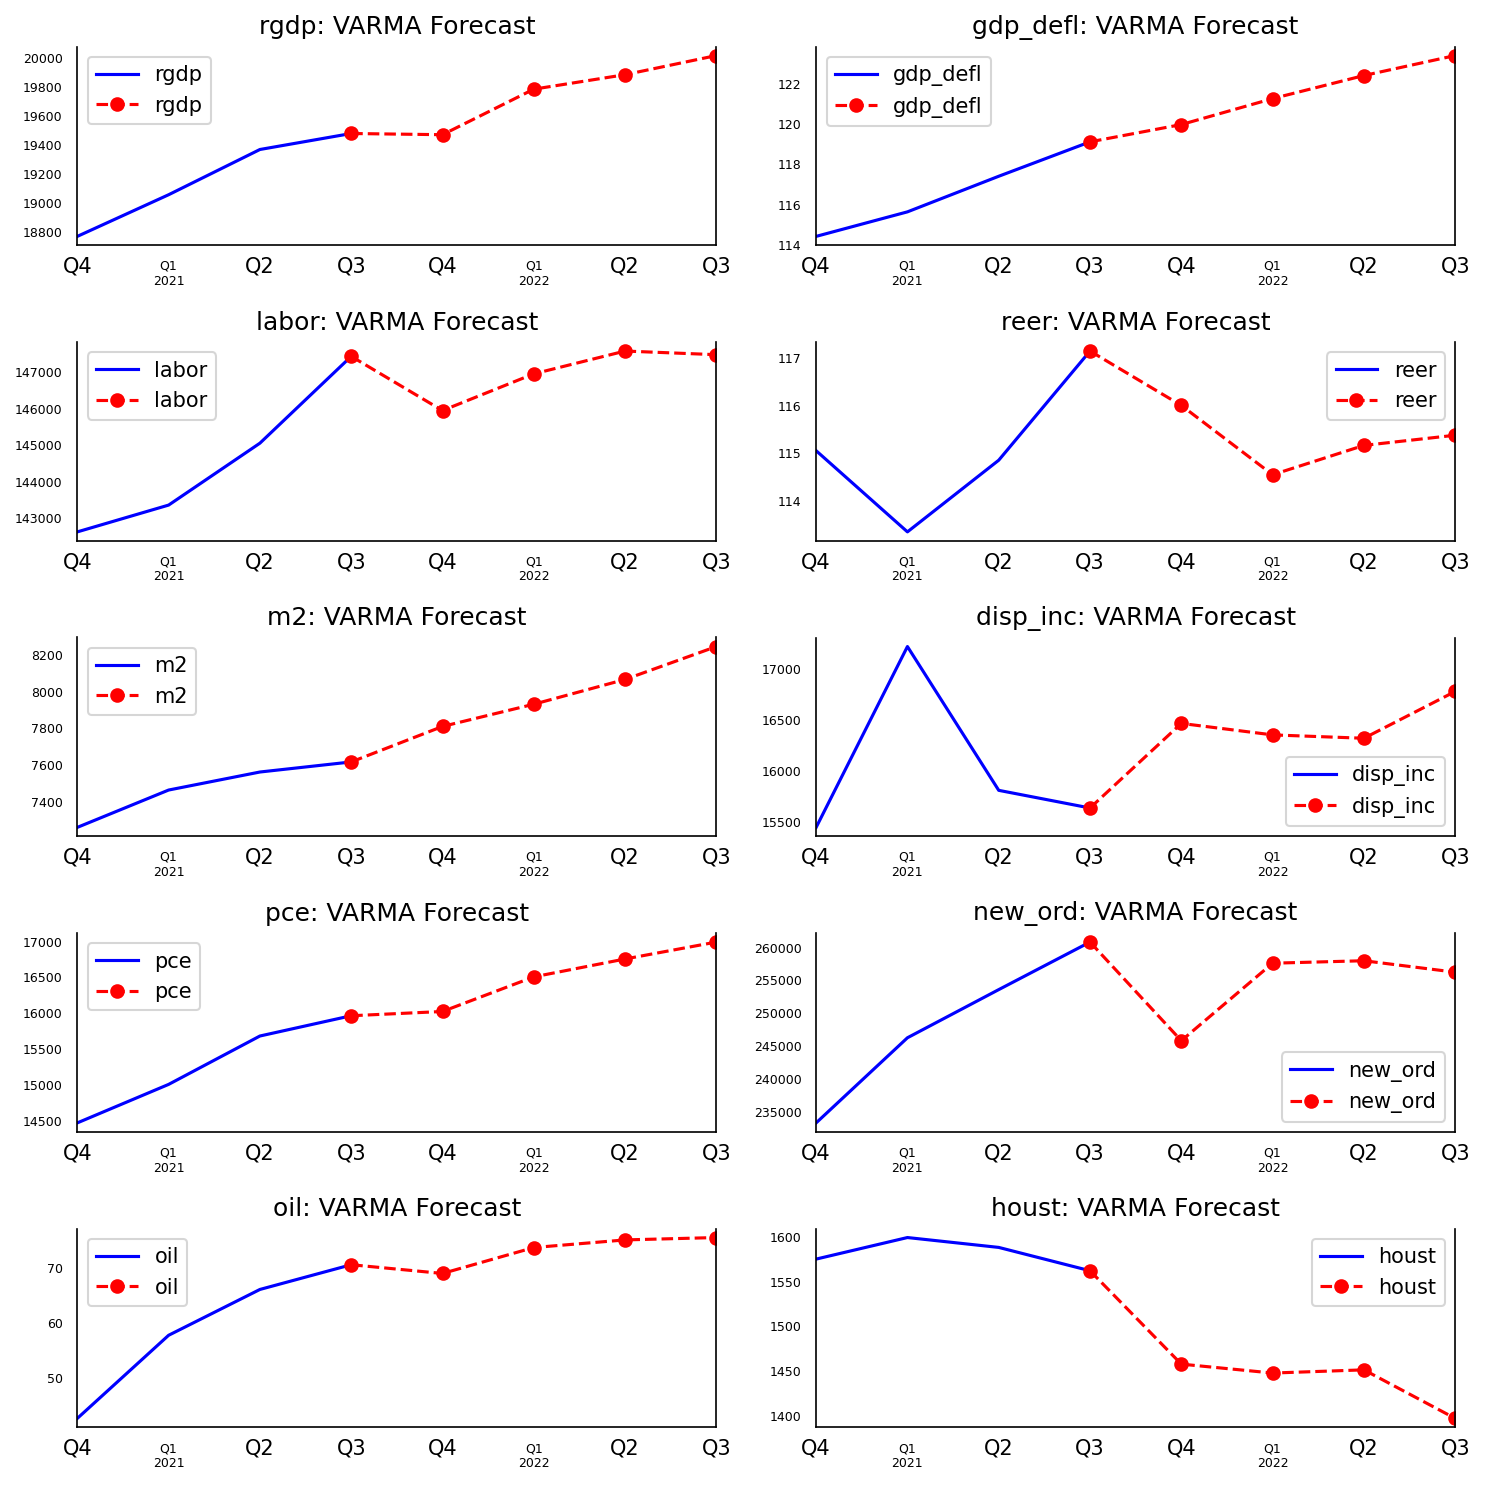

In [121]:
#Plotting our forecasts
fig, axes = plt.subplots(nrows=int(len(varma_fc_plot.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(varma_fc_plot.columns, axes.flatten())):
    varma_fc_plot[col].iloc[-8:-4].plot(legend=True, ax=ax, color='b')
    varma_fc_plot[col].iloc[-5:].plot(legend=True, ax=ax, marker='o', color='r', linestyle='--');
    ax.set_title(col + ": VARMA Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

## Comparing results for each model

As expected, we can see that each model resulted in a different forecast for each variable. Some variables are forecasted with a similar path among our models, while others differ completely. Also, take into consideration that, despite having already the actual data for monthly and daily variables like new_ord and oil, in our exercise we used an average aggregation of them in order to align these series to our variables of interest (i.e., rgdp and gdp_defl) that are released on a quarterly basis. Therefore, it would be impractical to assess the results obtained for these daily and monthly variables with already-released actual data. We will focus our analysis. For all these reasons, we will focus our attention only on the forecasts of rgdp and gdp_defl, which, as stated in the first section of this article, are the variables we are interested in.

### Comparing results for GDP

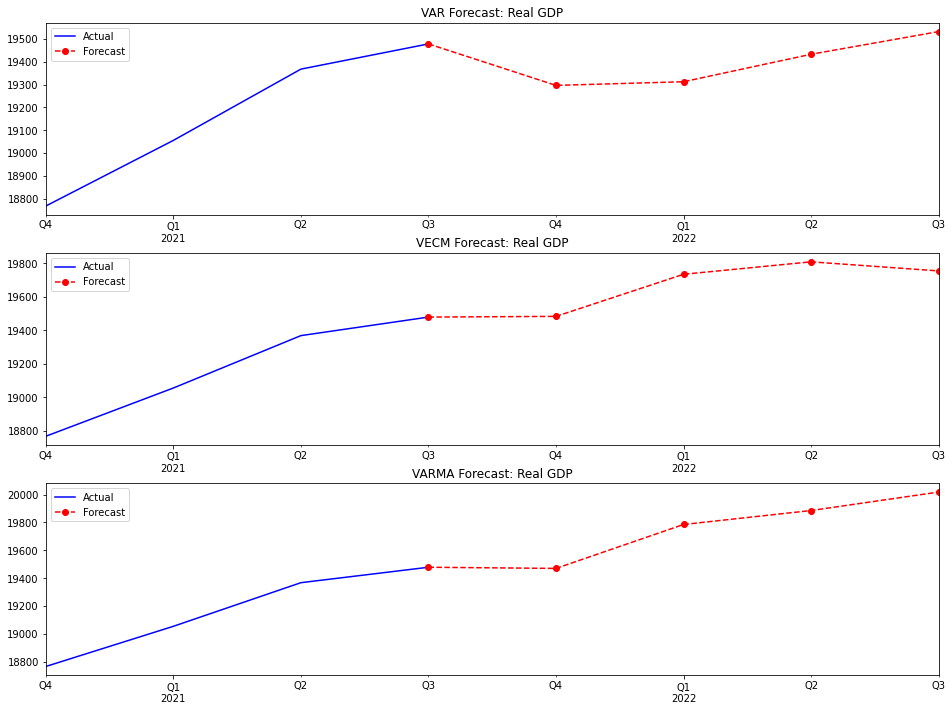

In [122]:
#GDP forecast comparison
plt.subplots(figsize=(16,12))

plt.subplot(311)
var_fc_plot['rgdp'].iloc[-8:-4].plot(legend=True, color='b')
var_fc_plot['rgdp'].iloc[-5:].plot(legend=True, marker='o', color='r', linestyle='--')
plt.legend(['Actual', 'Forecast'])
plt.title("VAR Forecast: Real GDP");

plt.subplot(312)
vecm_fc_plot['rgdp'].iloc[-8:-4].plot(legend=True, color='b')
vecm_fc_plot['rgdp'].iloc[-5:].plot(legend=True, marker='o', color='r', linestyle='--')
plt.legend(['Actual', 'Forecast'])
plt.title("VECM Forecast: Real GDP");

plt.subplot(313)
varma_fc_plot['rgdp'].iloc[-8:-4].plot(legend=True, color='b')
varma_fc_plot['rgdp'].iloc[-5:].plot(legend=True, marker='o', color='r', linestyle='--')
plt.legend(['Actual', 'Forecast'])
plt.title("VARMA Forecast: Real GDP");

### Comparing results for GDP deflator

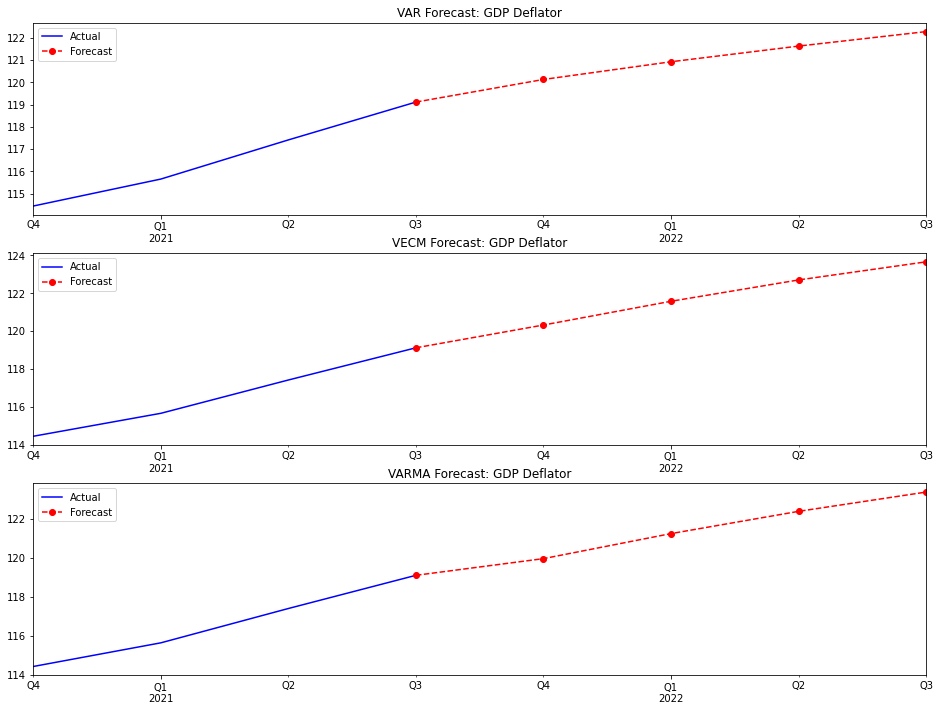

In [123]:
#Inflation forecast comparison
plt.subplots(figsize=(16,12))

plt.subplot(311)
var_fc_plot['gdp_defl'].iloc[-8:-4].plot(legend=True, color='b')
var_fc_plot['gdp_defl'].iloc[-5:].plot(legend=True, marker='o', color='r', linestyle='--')
plt.legend(['Actual', 'Forecast'])
plt.title("VAR Forecast: GDP Deflator");

plt.subplot(312)
vecm_fc_plot['gdp_defl'].iloc[-8:-4].plot(legend=True, color='b')
vecm_fc_plot['gdp_defl'].iloc[-5:].plot(legend=True, marker='o', color='r', linestyle='--')
plt.legend(['Actual', 'Forecast'])
plt.title("VECM Forecast: GDP Deflator");

plt.subplot(313)
varma_fc_plot['gdp_defl'].iloc[-8:-4].plot(legend=True, color='b')
varma_fc_plot['gdp_defl'].iloc[-5:].plot(legend=True, marker='o', color='r', linestyle='--')
plt.legend(['Actual', 'Forecast'])
plt.title("VARMA Forecast: GDP Deflator");

## Key takeaways

We have trained three multi-variate models and then made out-of-sample predictions to assess their ability to predict future values of the selected variables. Then we have made an attempt at using those models to make actual forecasts with a four-quarter time horizon. We have deliberately avoided the inclusion of observations for 2020 and 2021 to train our models (as we do think that these periods include the effects of a temporary shock to the macroeconomic environment), knowingly running the risk of underestimating uncertainty when producing forecasts. We also know that such models are better at estimating shorter time horizons, so our forecasts should probably be more accurate in earlier periods. When looking at the comparison of our models, we note that while for GDP deflator there is a general agreement among the models, for Real GDP levels the VECM and VARMA are less pessimistic than the simple VAR (at least for the first quarter forecasted - Q4'21). Although we learned that VARMA and VECM returned better results in our out-of-sample prediction exercise, we should be careful in discarding any result a priori. Being well informed about the latest developments and aware of economists' expectations with regard to these variables can be a form of "validation" when judging the outputs we obtained. For example, we know that currently inflation is running hot in the US and it's reasonable to expect that it continues on this way. Nevertheless, an informed market participant knows that the FED is considering hawkish measures to tame price increases. Furthermore, even if the Omicron variant has impacted considerably the growth in the last quarter of 2021, we may not exclude a positive growth during this same period, as Christmas is usually a booster for end-of-year growth. Finally, if we want to further improve our models, we may consider re-training them with the addition of a dummy variable that activates from Q1–2020, i.e. when Covid-19 hit our economy and our lives.